# Исследования для компании "Работа с заботой"
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Перед нами стоит несколько задач. 

Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
  
# Цель исследования:

  1) Изучить исходные данные.\
  2) Обработать данные.\
  3) Провести исследовательский анализ требуемых величин.\
  4) Выполнить подготовку и обучение моделей.\
  5) Выбрать лучшую модель и рассмотреть её метрики.\
  6) Написание итогового вывода.
  
   # Ход исследования:
  
   Данные получим из файлов train_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv, train_quit.csv, test_features.csv, test_target_quit.csv. О качестве данных ничего не известно, поэтому необходимо будет тщательно изучить их.
   
   На этапе предобработки данных найдём все пропущенные значения, обработаем их, удалим явные выбросы, избавимся от дубликатов. После этого исследуем зависимости между параметрами, построим необходимые диаграммы и приступим к обучению модели по прогнозам.
   
   Необходимо выполнить две задачи, делать это будем в порядке очереди.
   
   Таким образом, работа состоит из следующих этапов:
   
   - обзор полученных данных;
   - предобработка данных;
   - проведение анализа по конкретным столбцам;
   - обработка данных для модели МО;
   - обучение моделей;
   - выбор лучшей модели;
   - объяснение закономерностей предсказания модели;
   - написание общего вывода.

In [1]:
!pip install -U scikit-learn -q
!pip install --upgrade pandas -q # -q убирает необязательные выводы в командах Linux
!pip install -U seaborn -q
!pip install -U matplotlib -q
!pip install --force-reinstall scipy==1.8.0 -q
!pip install -U phik -q
!pip install -U shap -q
!pip install imbalanced-learn -q
!pip install -U imbalanced-learn -q
!pip install transformers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [2]:
# Добавление библиотек и функций:
import warnings
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import phik
from phik.report import plot_correlation_matrix

from scipy.stats import spearmanr

from scipy import stats as st

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, SMOTENC
from imblearn.combine import SMOTETomek

## Задача №1: "Предсказание уровня удовлетворённости сотрудника"

### Загрузка данных

Загружаем первые три таблицы и выводим общую информацию о них.

In [3]:
# Загрузка данных:
train_job_srate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_job_srate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

display(train_job_srate.head())
train_job_srate.info()
display(test_features.head())
test_features.info()
display(test_job_srate.head())
test_job_srate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


#### Вывод:
Сразу видим пару пропущенных значений в первой и второй таблицах. Благо, их немного. С типами данных нигде проблем нет. Названия столбцов записаны приемлемо. Можем переходить к предобработке данных.

### Предобработка данных

Проверяем таблицы на дубликаты.

In [4]:
# Проверка на явные дубликаты:
print(train_job_srate.duplicated().sum())
print(test_features.duplicated().sum())
print(test_job_srate.duplicated().sum())

0
0
0


In [5]:
# Проверка на неявные дубликаты:
print(train_job_srate['id'].duplicated().sum())
print(test_features['id'].duplicated().sum())
print(test_job_srate['id'].duplicated().sum())

0
0
0


Дубликатов нигде не обнаружено, посмотрим на запись данных.

In [6]:
# Проверяем корректную запись данных первой таблицы:
print(train_job_srate['dept'].unique())
print(train_job_srate['level'].unique())
print(train_job_srate['workload'].unique())
print(train_job_srate['last_year_promo'].unique())
print(train_job_srate['last_year_violations'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


В первой таблице всё хорошо.

In [7]:
# Проверяем корректную запись данных первой таблицы:
print(test_features['dept'].unique())
print(test_features['level'].unique())
print(test_features['workload'].unique())
print(test_features['last_year_promo'].unique())
print(test_features['last_year_violations'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


В тестовых данных наблюдаются "пробелы". Заменим их на NaN'ы.

In [8]:
# Заполнение пробелов:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

print(test_features['dept'].unique())
print(test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


In [9]:
# Посмотрим на количесвто пропусков в тестовых данных:
print(test_features['dept'].isna().sum())
print(test_features['workload'].isna().sum())

3
1


Количество пропусков и правда мало. Подготовим небольшой пайплайн для замены NaN'ов на моды и применим его к тренировочным и тестовым данным.

In [10]:
# Подготовка пайплайна:
nan_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent'))])

# Применяем пайплайн к датасетам:
train_job_1 = train_job_srate.drop('job_satisfaction_rate', axis=1)
train_job = nan_pipe.fit_transform(train_job_1)

train_job_srate_full = pd.DataFrame(train_job, columns=nan_pipe.get_feature_names_out(train_job_1.columns))
train_job_srate_full['job_satisfaction_rate'] = train_job_srate['job_satisfaction_rate']
display(train_job_srate_full)
train_job_srate_full.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   object 
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   object 
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   object 
 8   salary                 4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), object(9)
memory usage: 312.6+ KB


In [11]:
# Для тестовых данных:
test_job = nan_pipe.transform(test_features)
test_features = pd.DataFrame(test_job, columns=nan_pipe.get_feature_names_out(test_features.columns))
display(test_features.head())
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   object
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   object
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   object
 8   salary                 2000 non-null   object
dtypes: object(9)
memory usage: 140.8+ KB


Пропуски успешно устранены.

#### Вывод:
В ходе предобработки данных была выполнена проверка на дубликаты, на корректность заполнения таблиц, а также заполнены немногочисленные пропуски.

### Исследовательский анализ данных

Переходим к исследовательскому анализу данных. Рассматривать будем зависимости из первой таблицы (тренировочные данные), разделяя сотрудников по их проф. уровню. Начнём с графиков размаха для количественных данных.

In [12]:
# Вернём прежнее название начальной таблицы:
train_job_srate = train_job_srate_full

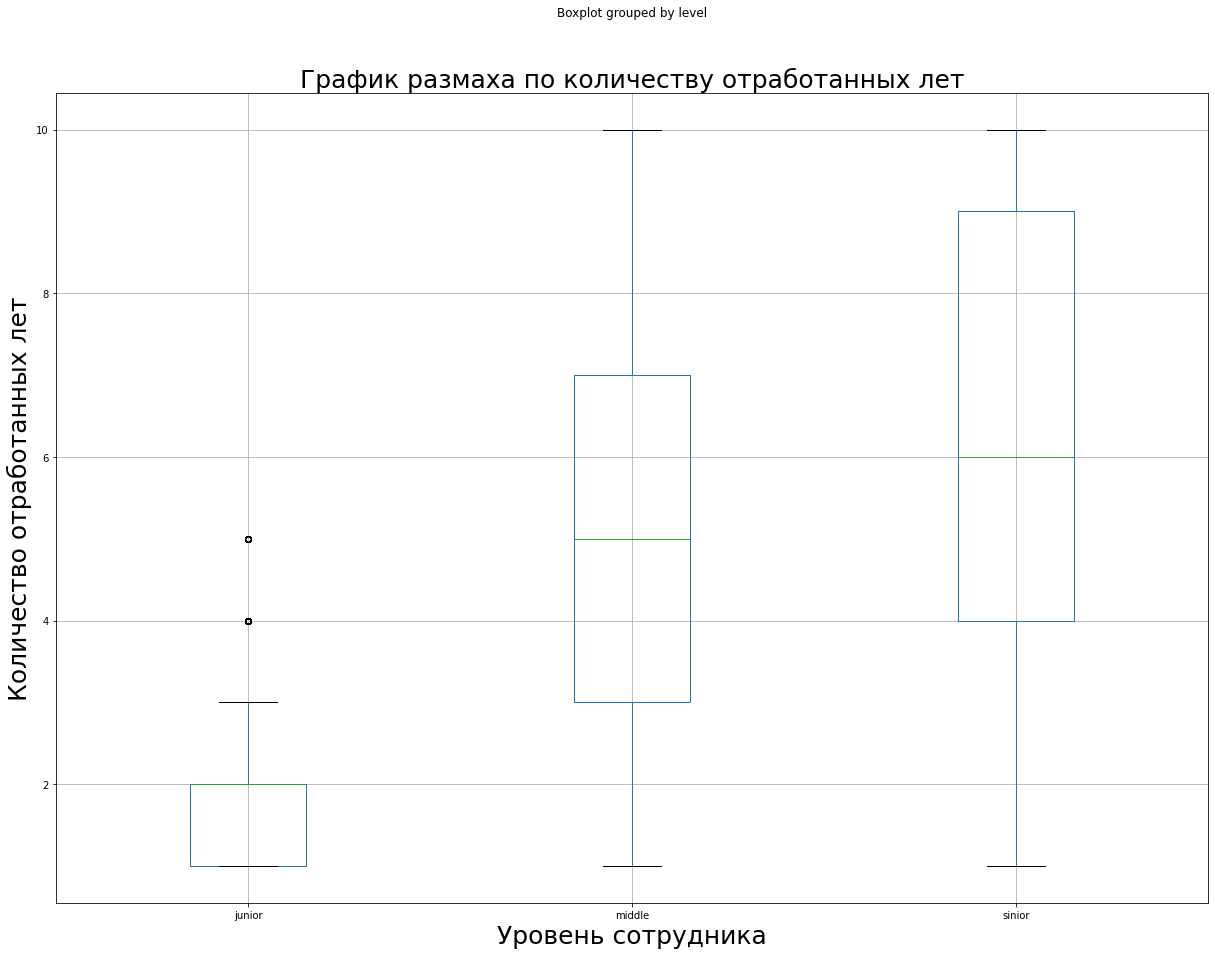

,count,unique,top,freq
level,,,,
junior,1898,5,1,851
middle,1744,10,5,299
sinior,358,10,10,50


In [13]:
# График размаха по количеству отработанных лет:
train_job_srate.boxplot(column='employment_years', by='level', figsize=(20, 15))
plt.title('График размаха по количеству отработанных лет', fontsize=25)
plt.ylabel('Количество отработанных лет', fontsize=25)
plt.xlabel('Уровень сотрудника', fontsize=25)
plt.show()

train_job_srate.groupby('level')['employment_years'].describe()

Все сотрудники работают в компании как минимум год, некоторые "мидлы" и "сеньоры" по 10 лет. Есть несколько засидевшихся "джунов". Интересно, что это за работники? Аномалий и явных выбросов не обнаружено.

In [14]:
# Выведем информацию о "джунах-старожилах":
display(train_job_srate[(train_job_srate['employment_years'] >= 4) & (train_job_srate['level'] == 'junior')])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3,171431,technology,junior,low,4,no,no,2,18000,0.37
52,696387,sales,junior,low,4,no,no,4,12000,0.60
109,303318,marketing,junior,high,5,no,no,1,33600,0.37
135,242056,technology,junior,high,4,no,no,5,46800,0.77
138,187280,sales,junior,high,4,no,no,5,34800,0.80
...,...,...,...,...,...,...,...,...,...,...
3803,510512,sales,junior,medium,4,no,no,4,27600,0.77
3832,247544,technology,junior,medium,4,no,no,2,30000,0.41
3861,802109,sales,junior,low,5,no,no,4,19200,0.82
3868,408957,purchasing,junior,high,4,no,no,4,36000,0.84


Оказалось, что их достаточно много. Загруженность и оценки компании у них тоже разные.

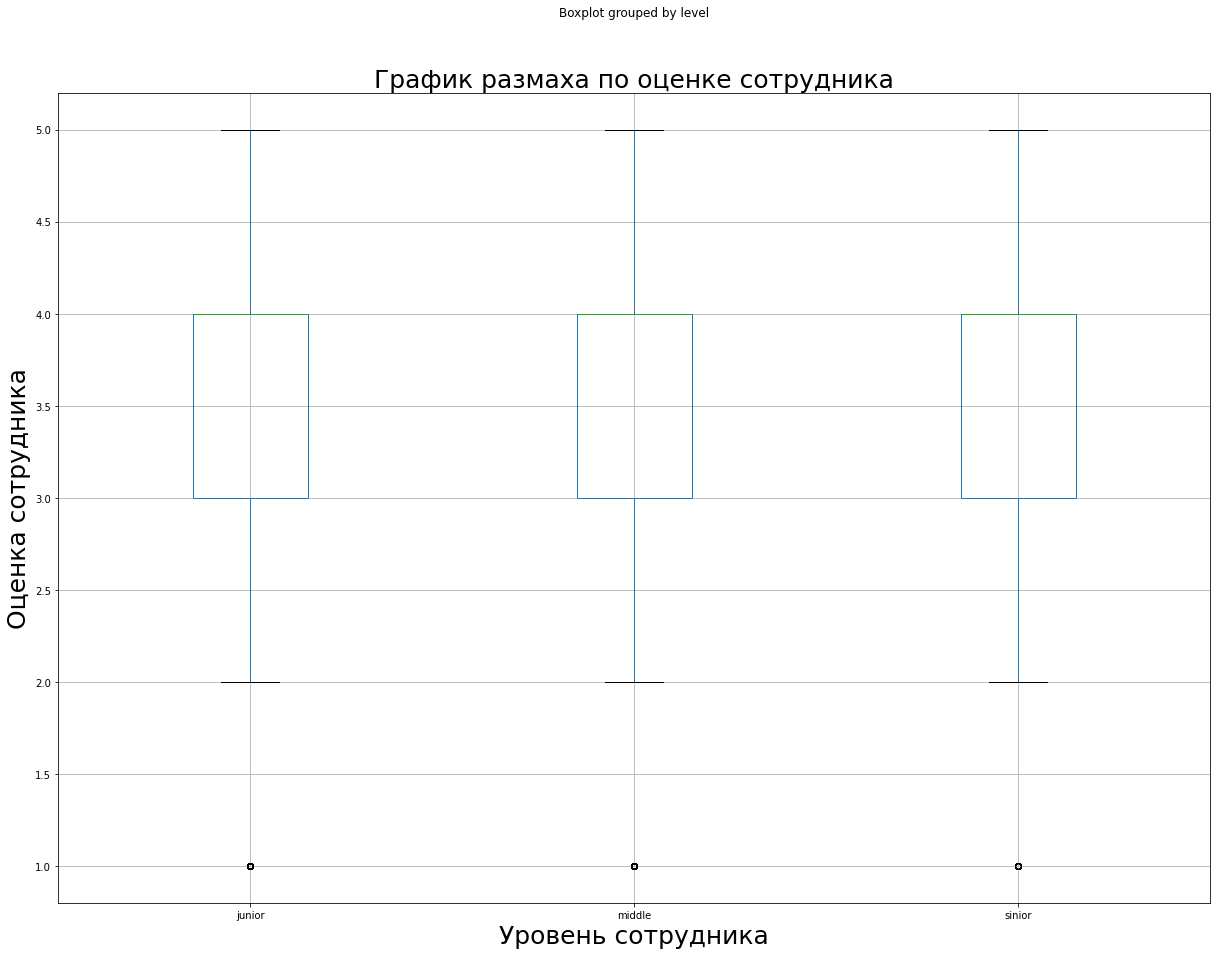

,count,unique,top,freq
level,,,,
junior,1898,5,4,741
middle,1744,5,4,719
sinior,358,5,4,143


In [15]:
# График размаха по количеству отработанных лет:
train_job_srate.boxplot(column='supervisor_evaluation', by='level', figsize=(20, 15))
plt.title('График размаха по оценке сотрудника', fontsize=25)
plt.ylabel('Оценка сотрудника', fontsize=25)
plt.xlabel('Уровень сотрудника', fontsize=25)
plt.show()

train_job_srate.groupby('level')['supervisor_evaluation'].describe()

График размаха ничего не показал, эту зависимость лучше рассмотреть по гистограммам.

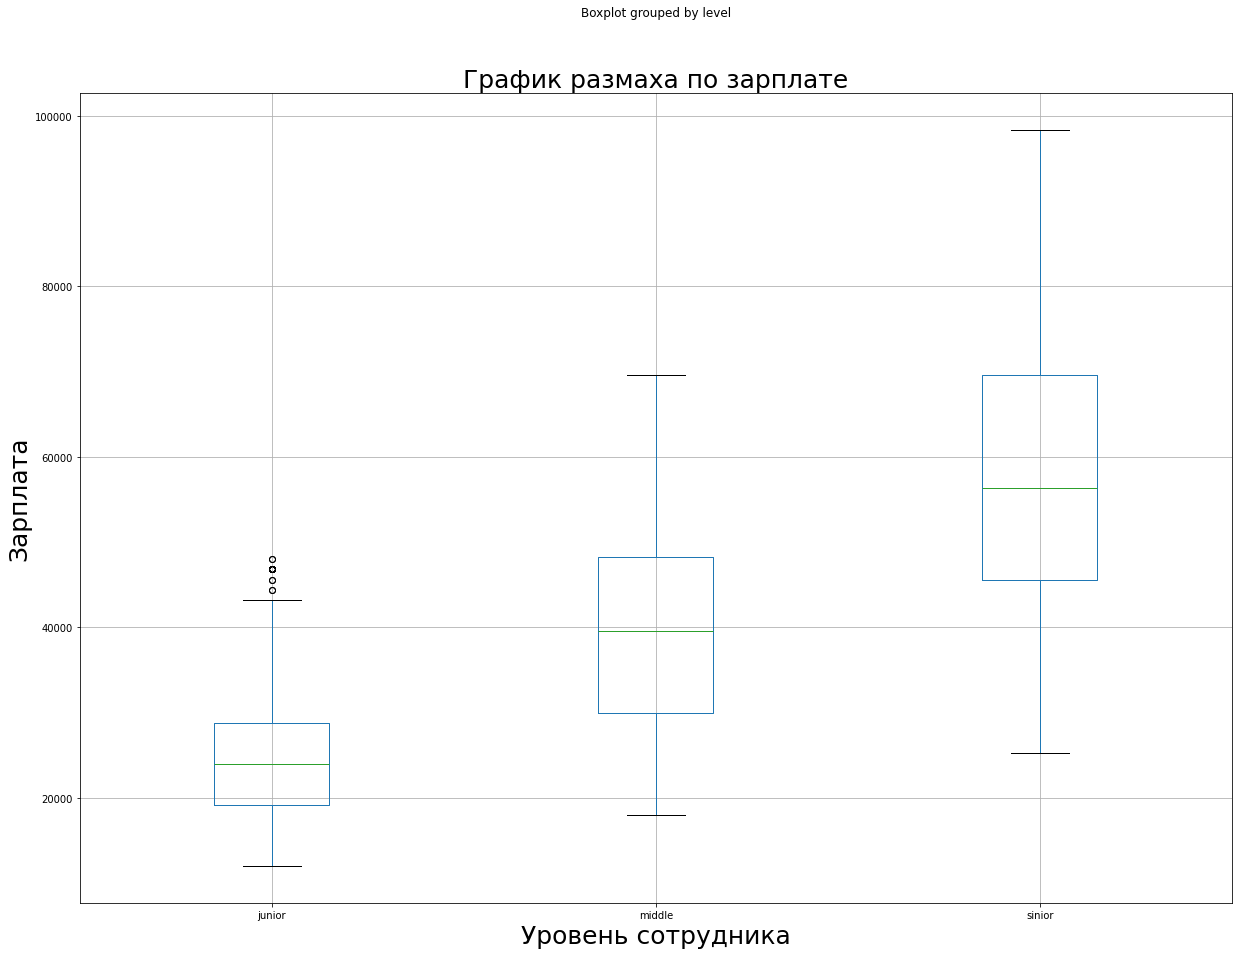

,count,unique,top,freq
level,,,,
junior,1898,31,21600,152
middle,1744,44,33600,106
sinior,358,54,45600,18


In [16]:
# График размаха по зарплате:
train_job_srate.boxplot(column='salary', by='level', figsize=(20, 15))
plt.title('График размаха по зарплате', fontsize=25)
plt.ylabel('Зарплата', fontsize=25)
plt.xlabel('Уровень сотрудника', fontsize=25)
plt.show()

train_job_srate.groupby('level')['salary'].describe()

Явных выбросов не обнаружено, данные чисты. Понятная закономерность: чем выше уровень, тем больше зарплата.

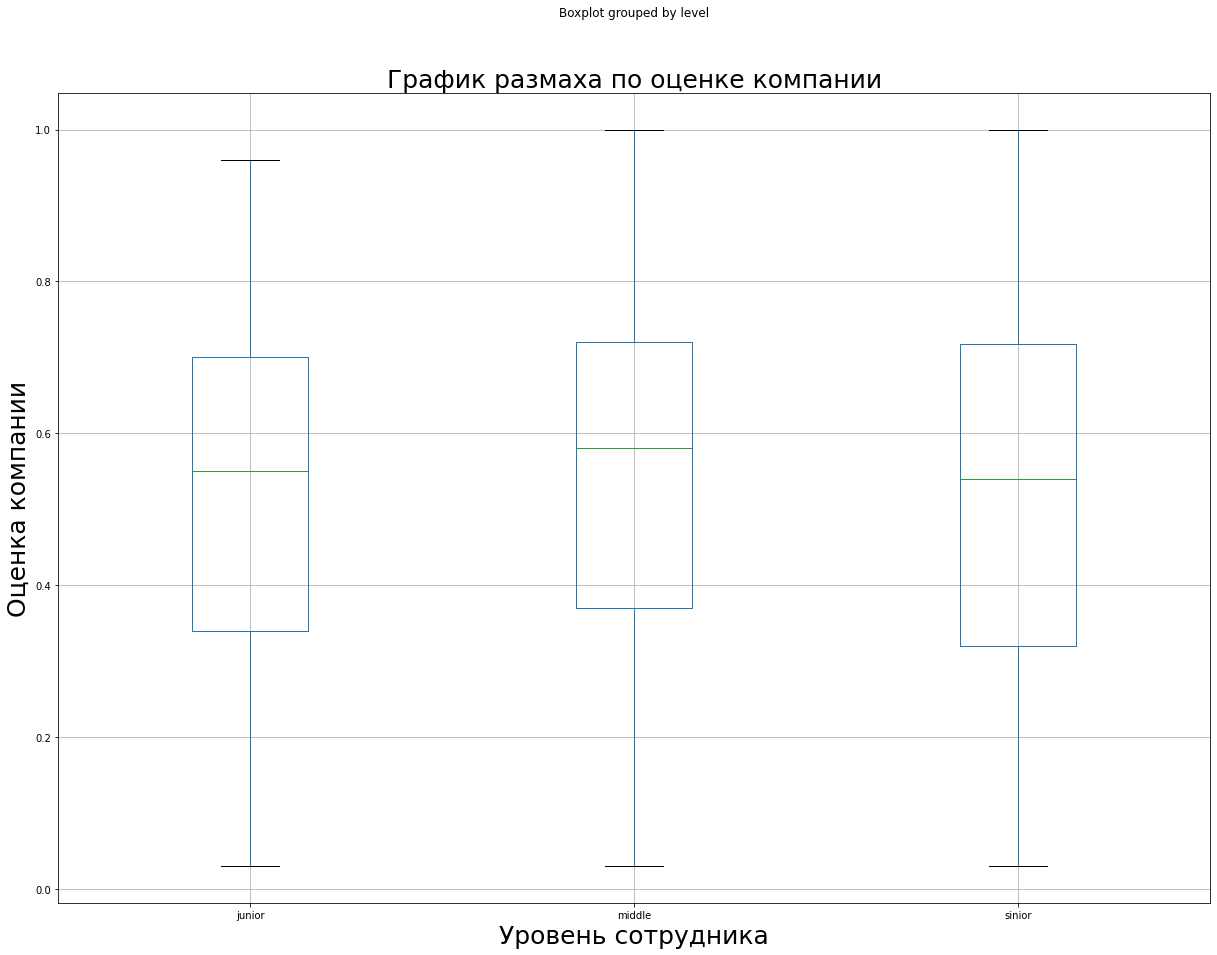

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
junior,1898.0,0.523330,0.226491,0.03,0.34,0.55,0.7000,0.96
middle,1744.0,0.548377,0.220608,0.03,0.37,0.58,0.7200,1.00
sinior,358.0,0.520475,0.238199,0.03,0.32,0.54,0.7175,1.00


In [17]:
# График размаха по оценке компании:
train_job_srate.boxplot(column='job_satisfaction_rate', by='level', figsize=(20, 15))
plt.title('График размаха по оценке компании', fontsize=25)
plt.ylabel('Оценка компании', fontsize=25)
plt.xlabel('Уровень сотрудника', fontsize=25)
plt.show()

train_job_srate.groupby('level')['job_satisfaction_rate'].describe()

Хоть и не на много, но "мидлы" оценивают работу лучше остальных.

##### Промежуточный вывод:
Анализ графиков размаха дал следующий результат:
  - Все сотрудники работают в компании как минимум год, некоторые "мидлы" и "сеньоры" по 10 лет;
  - Чем выше уровень сотрудника, тем больше его зарплата;
  - Хоть и не на много, но "мидлы" оценивают работу лучше остальных.
  
Аномалий и явных выбросов обнаружено не было.

Переходим к построению гистограмм. Деление по уровню сотрудников остаётся, для джунов будет использоваться зелёный цвет, для мидлов - жёлтый, для сеньоров - красный.

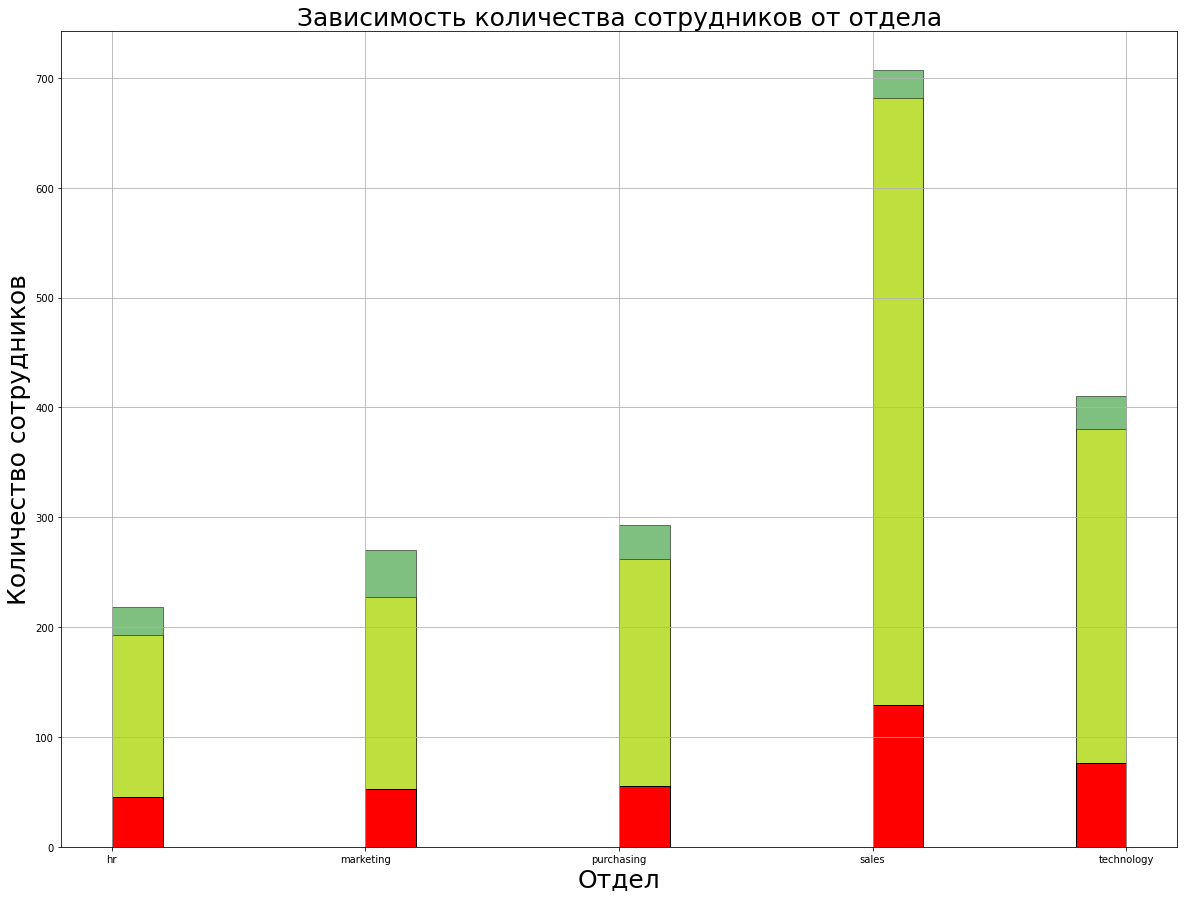

Распределение джунов по отделам:
 count      1898
unique        5
top       sales
freq        707
Name: dept, dtype: object

Распределение мидлов по отделам:
 count      1744
unique        5
top       sales
freq        682
Name: dept, dtype: object

Распределение сеньоров по отделам:
 count       358
unique        5
top       sales
freq        129
Name: dept, dtype: object


In [18]:
#Гистограмма по отделам:
train_job_srate[train_job_srate['level']=='junior'].sort_values(by='dept', ascending=True)['dept'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
train_job_srate[train_job_srate['level']=='middle'].sort_values(by='dept', ascending=True)['dept'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='yellow')
train_job_srate[train_job_srate['level']=='sinior'].sort_values(by='dept', ascending=True)['dept'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1,  
                                                                      color='red')
plt.title('Зависимость количества сотрудников от отдела', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Отдел', fontsize=25)
plt.show()

print('Распределение джунов по отделам:\n', train_job_srate[train_job_srate['level']=='junior']['dept'].describe())
print('')
print('Распределение мидлов по отделам:\n', train_job_srate[train_job_srate['level']=='middle']['dept'].describe())
print('')
print('Распределение сеньоров по отделам:\n', train_job_srate[train_job_srate['level']=='sinior']['dept'].describe())

В отеделе продаж задействовано больше всего сотрудников всех мастей. Распределение сеньоров по всем отделам примерно одинаково.

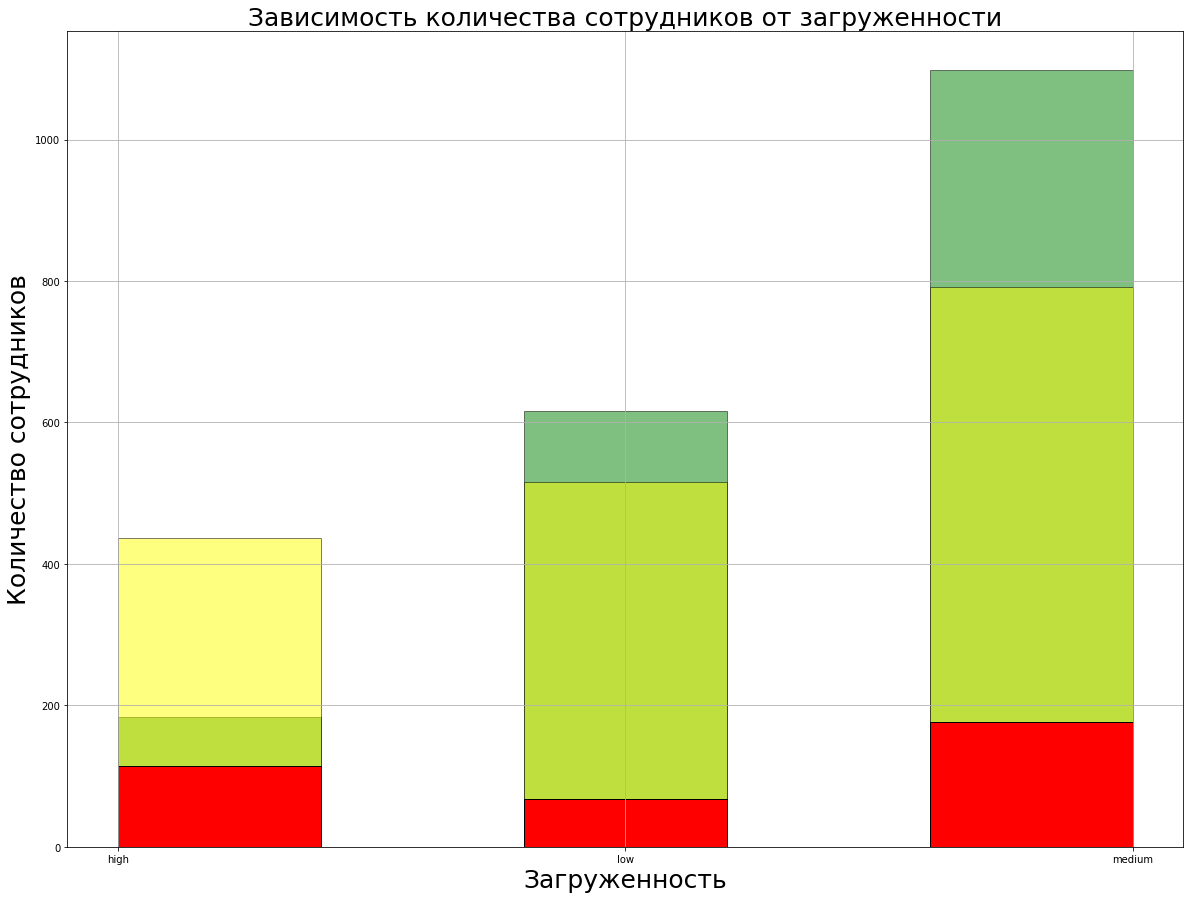

Распределение джунов по загруженности:
 count       1898
unique         3
top       medium
freq        1098
Name: workload, dtype: object

Распределение мидлов по загруженности:
 count       1744
unique         3
top       medium
freq         792
Name: workload, dtype: object

Распределение сеньоров по загруженности:
 count        358
unique         3
top       medium
freq         176
Name: workload, dtype: object


In [19]:
#Гистограмма по загруженности:
train_job_srate[train_job_srate['level']=='junior'].sort_values(by='workload', ascending=True)['workload'].hist(
                                                                      bins=5, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
train_job_srate[train_job_srate['level']=='middle'].sort_values(by='workload', ascending=True)['workload'].hist(
                                                                      bins=5,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='yellow')
train_job_srate[train_job_srate['level']=='sinior'].sort_values(by='workload', ascending=True)['workload'].hist(
                                                                      bins=5, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1,  
                                                                      color='red')
plt.title('Зависимость количества сотрудников от загруженности', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Загруженность', fontsize=25)
plt.show()

print('Распределение джунов по загруженности:\n', train_job_srate[train_job_srate['level']=='junior']['workload'].describe())
print('')
print('Распределение мидлов по загруженности:\n', train_job_srate[train_job_srate['level']=='middle']['workload'].describe())
print('')
print('Распределение сеньоров по загруженности:\n', train_job_srate[train_job_srate['level']=='sinior']['workload'].describe())

Значимо больше остальных заняты мидлы. Большинство сотрудников оценивают свою загруженность средне.

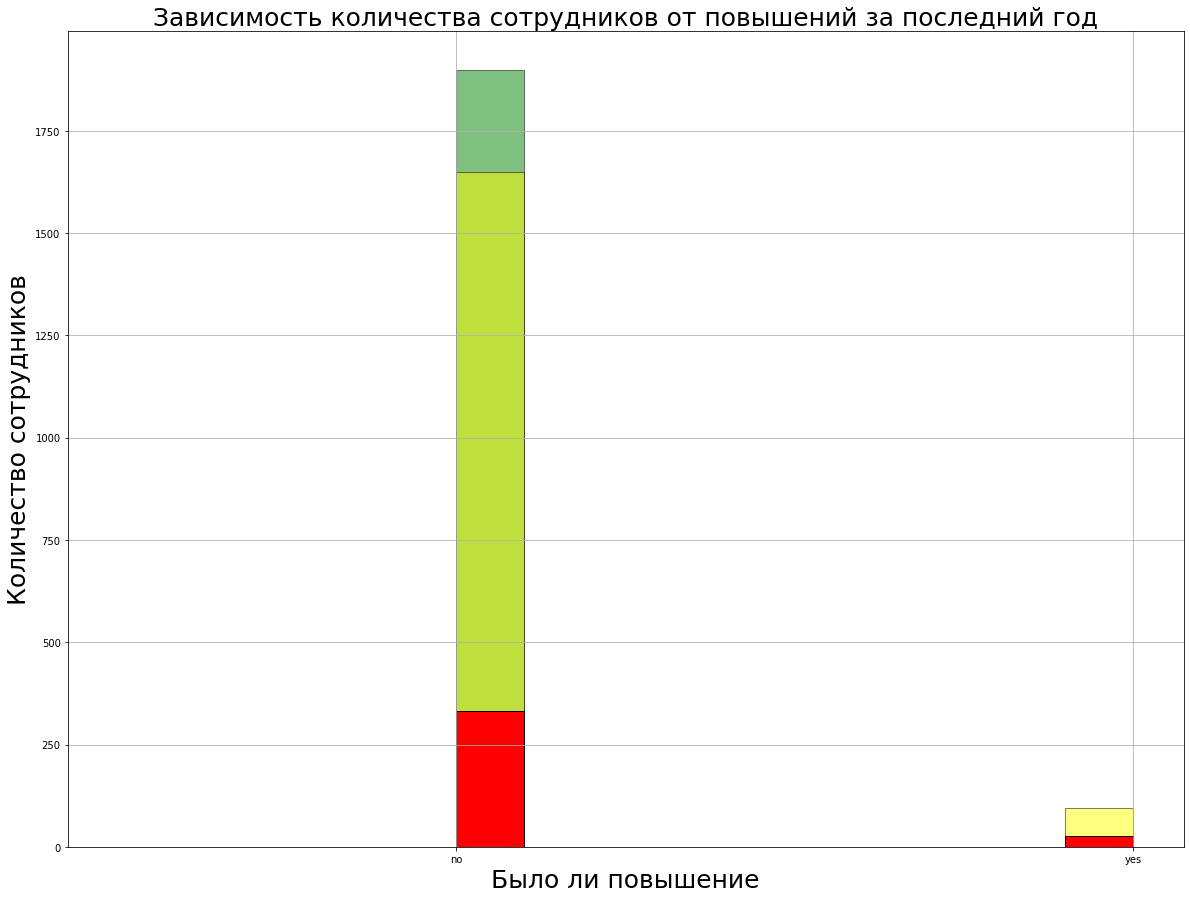

Распределение джунов по повышениям:
 count       1898
unique         3
top       medium
freq        1098
Name: workload, dtype: object

Распределение мидлов по повышениям:
 count       1744
unique         3
top       medium
freq         792
Name: workload, dtype: object

Распределение сеньоров по повышениям:
 count        358
unique         3
top       medium
freq         176
Name: workload, dtype: object


In [20]:
#Гистограмма по повышениям:
train_job_srate[train_job_srate['level']=='junior'].sort_values(by='last_year_promo', ascending=True)['last_year_promo'].hist( 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
train_job_srate[train_job_srate['level']=='middle'].sort_values(by='last_year_promo', ascending=True)['last_year_promo'].hist(
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='yellow')
train_job_srate[train_job_srate['level']=='sinior'].sort_values(by='last_year_promo', ascending=True)['last_year_promo'].hist(
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1,  
                                                                      color='red')
plt.title('Зависимость количества сотрудников от повышений за последний год', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Было ли повышение', fontsize=25)
plt.show()

print('Распределение джунов по повышениям:\n', train_job_srate[train_job_srate['level']=='junior']['workload'].describe())
print('')
print('Распределение мидлов по повышениям:\n', train_job_srate[train_job_srate['level']=='middle']['workload'].describe())
print('')
print('Распределение сеньоров по повышениям:\n', train_job_srate[train_job_srate['level']=='sinior']['workload'].describe())

Интересно, повышений не было у большинства уже очень давно. Абсолютно все джуны не продвинулись за год по карьерной лестнице.

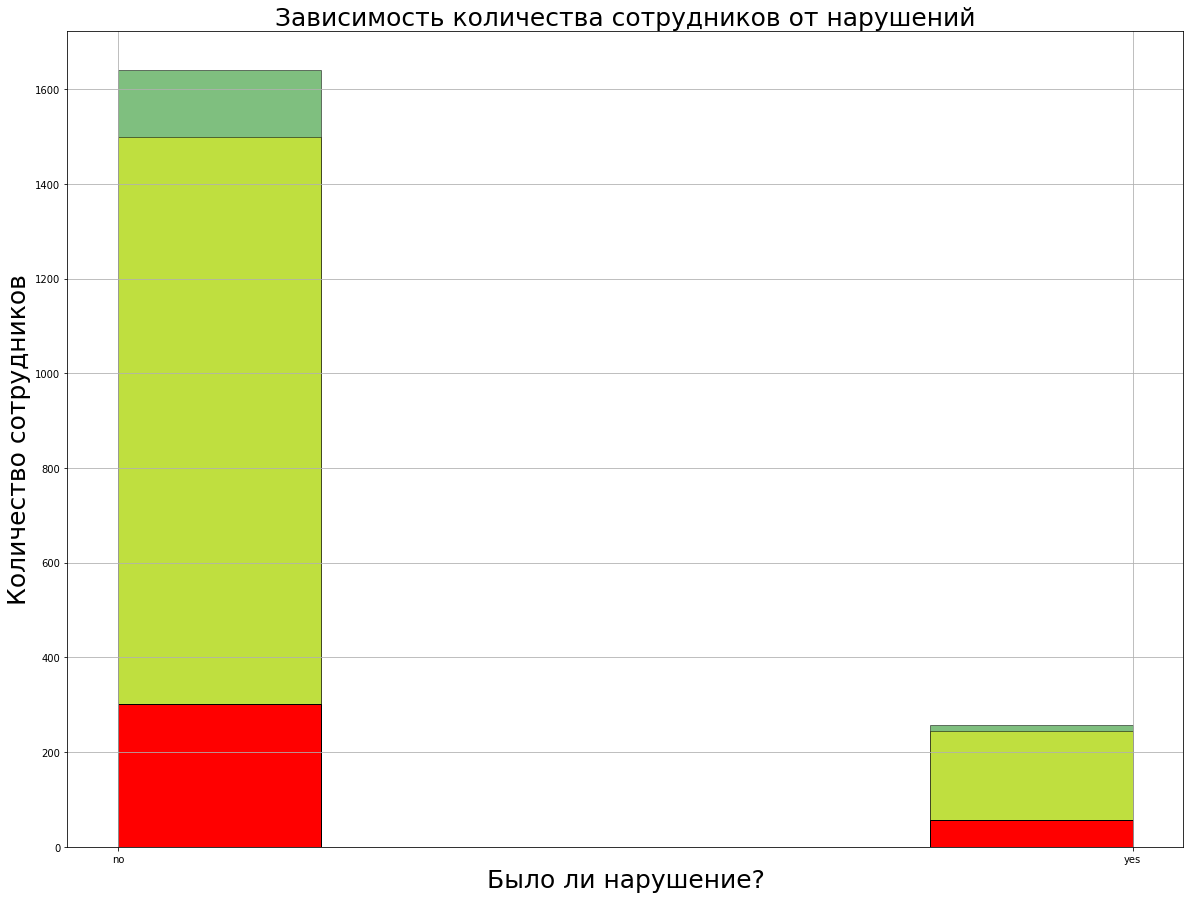

Распределение джунов по нарушениям:
 count     1898
unique       2
top         no
freq      1640
Name: last_year_violations, dtype: object

Распределение мидлов по нарушениям:
 count     1744
unique       2
top         no
freq      1499
Name: last_year_violations, dtype: object

Распределение сеньоров по нарушениям:
 count     358
unique      2
top        no
freq      302
Name: last_year_violations, dtype: object


In [21]:
#Гистограмма по загруженности:
train_job_srate[train_job_srate['level']=='junior'].sort_values(by='last_year_violations', ascending=True)['last_year_violations'].hist(
                                                                      bins=5, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
train_job_srate[train_job_srate['level']=='middle'].sort_values(by='last_year_violations', ascending=True)['last_year_violations'].hist(
                                                                      bins=5,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='yellow')
train_job_srate[train_job_srate['level']=='sinior'].sort_values(by='last_year_violations', ascending=True)['last_year_violations'].hist(
                                                                      bins=5, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1,  
                                                                      color='red')
plt.title('Зависимость количества сотрудников от нарушений', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Было ли нарушение?', fontsize=25)
plt.show()

print('Распределение джунов по нарушениям:\n', train_job_srate[train_job_srate['level']=='junior']['last_year_violations'].describe())
print('')
print('Распределение мидлов по нарушениям:\n', train_job_srate[train_job_srate['level']=='middle']['last_year_violations'].describe())
print('')
print('Распределение сеньоров по нарушениям:\n', train_job_srate[train_job_srate['level']=='sinior']['last_year_violations'].describe())

Джуны и мидлы нарушают примерно одинаково. Примерно 1/8 часть всех сотрудников где-то провинилась.

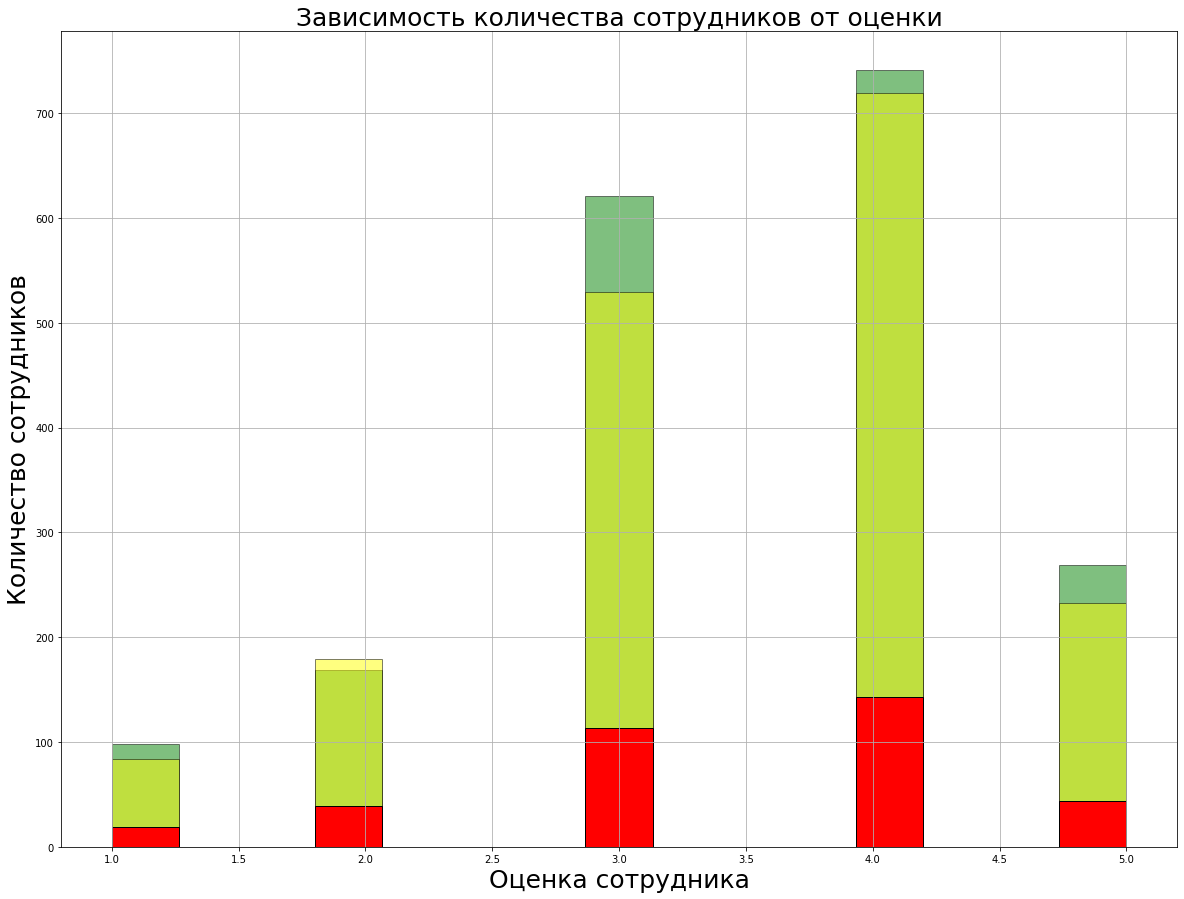

Распределение джунов по оценке:
 count     1898
unique       5
top          4
freq       741
Name: supervisor_evaluation, dtype: int64

Распределение мидлов по оценке:
 count     1744
unique       5
top          4
freq       719
Name: supervisor_evaluation, dtype: int64

Распределение сеньоров по оценке:
 count     358
unique      5
top         4
freq      143
Name: supervisor_evaluation, dtype: int64


In [22]:
#Гистограмма по оценке сотрудника:
train_job_srate[train_job_srate['level']=='junior'].sort_values(by='supervisor_evaluation', ascending=True)['supervisor_evaluation'].hist( 
                                                                      bins = 15,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
train_job_srate[train_job_srate['level']=='middle'].sort_values(by='supervisor_evaluation', ascending=True)['supervisor_evaluation'].hist(
                                                                      bins = 15,                                                                  
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='yellow')
train_job_srate[train_job_srate['level']=='sinior'].sort_values(by='supervisor_evaluation', ascending=True)['supervisor_evaluation'].hist(
                                                                      bins = 15,                                                                      
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1,  
                                                                      color='red')
plt.title('Зависимость количества сотрудников от оценки', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Оценка сотрудника', fontsize=25)
plt.show()

print('Распределение джунов по оценке:\n', train_job_srate[train_job_srate['level']=='junior']['supervisor_evaluation'].describe())
print('')
print('Распределение мидлов по оценке:\n', train_job_srate[train_job_srate['level']=='middle']['supervisor_evaluation'].describe())
print('')
print('Распределение сеньоров по оценке:\n', train_job_srate[train_job_srate['level']=='sinior']['supervisor_evaluation'].describe())

Подавляющее большинство сотрудников оценивается "средне" или "чуть выше среднего". Отличных сотрудников меньше, чем тех, у кого по рейтингу "1" или "2".

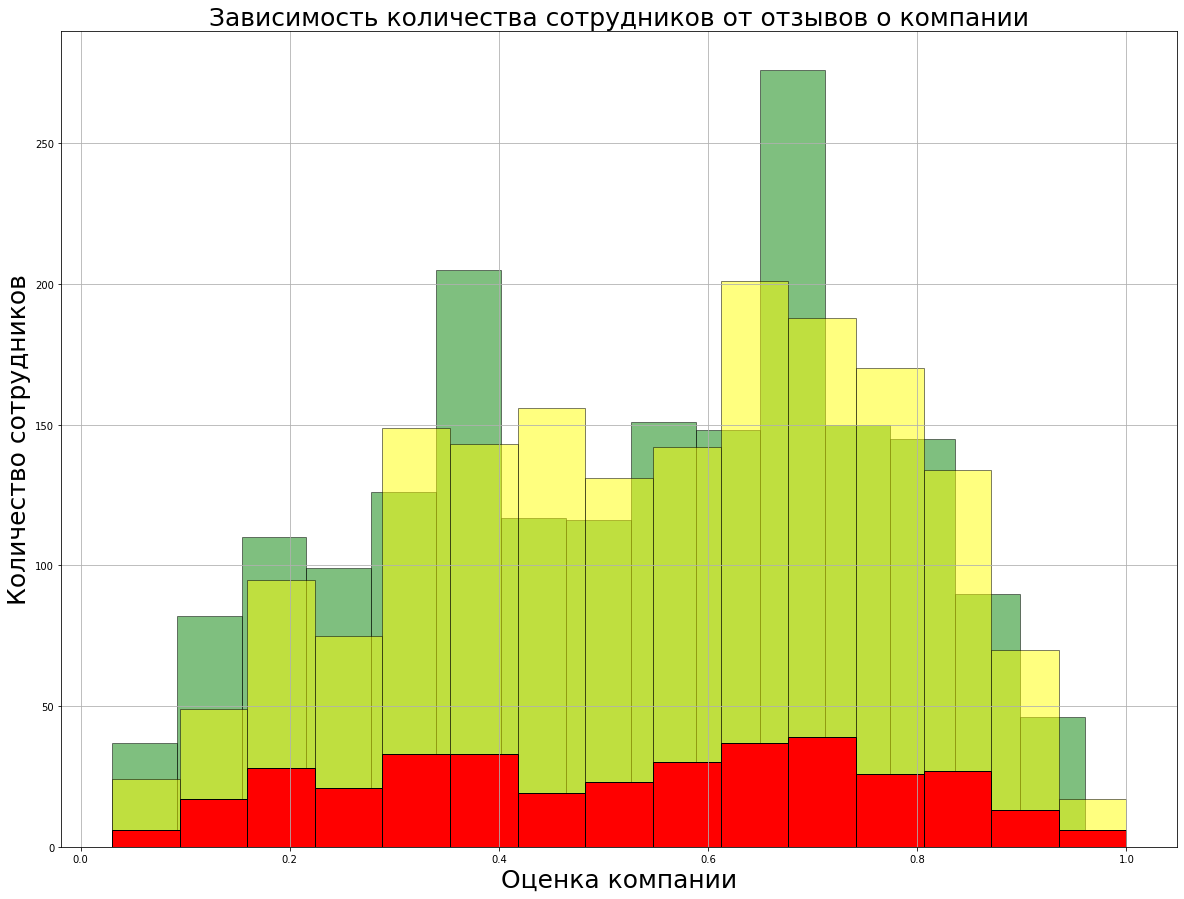

Распределение джунов по отзывам:
 count    1898.000000
mean        0.523330
std         0.226491
min         0.030000
25%         0.340000
50%         0.550000
75%         0.700000
max         0.960000
Name: job_satisfaction_rate, dtype: float64

Распределение мидлов по отзывам:
 count    1744.000000
mean        0.548377
std         0.220608
min         0.030000
25%         0.370000
50%         0.580000
75%         0.720000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Распределение сеньоров по отзывам:
 count    358.000000
mean       0.520475
std        0.238199
min        0.030000
25%        0.320000
50%        0.540000
75%        0.717500
max        1.000000
Name: job_satisfaction_rate, dtype: float64


In [23]:
#Гистограмма по оценке компании:
train_job_srate[train_job_srate['level']=='junior'].sort_values(by='job_satisfaction_rate', ascending=True)['job_satisfaction_rate'].hist( 
                                                                      bins = 15,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
train_job_srate[train_job_srate['level']=='middle'].sort_values(by='job_satisfaction_rate', ascending=True)['job_satisfaction_rate'].hist(
                                                                      bins = 15,                                                                  
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='yellow')
train_job_srate[train_job_srate['level']=='sinior'].sort_values(by='job_satisfaction_rate', ascending=True)['job_satisfaction_rate'].hist(
                                                                      bins = 15,                                                                      
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1,  
                                                                      color='red')
plt.title('Зависимость количества сотрудников от отзывов о компании', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Оценка компании', fontsize=25)
plt.show()

print('Распределение джунов по отзывам:\n', train_job_srate[train_job_srate['level']=='junior']['job_satisfaction_rate'].describe())
print('')
print('Распределение мидлов по отзывам:\n', train_job_srate[train_job_srate['level']=='middle']['job_satisfaction_rate'].describe())
print('')
print('Распределение сеньоров по отзывам:\n', train_job_srate[train_job_srate['level']=='sinior']['job_satisfaction_rate'].describe())

По оценке компании можно сказать следующее: 
  - большинство джунов ставят либо 0.7, либо 0.4; 
  - большинство мидлов ставят от 0.6 до 0.8;
  - сеньоры распределили оценки более-менее равномерно.

Оценим распределение количественных признаков относительно целевого.

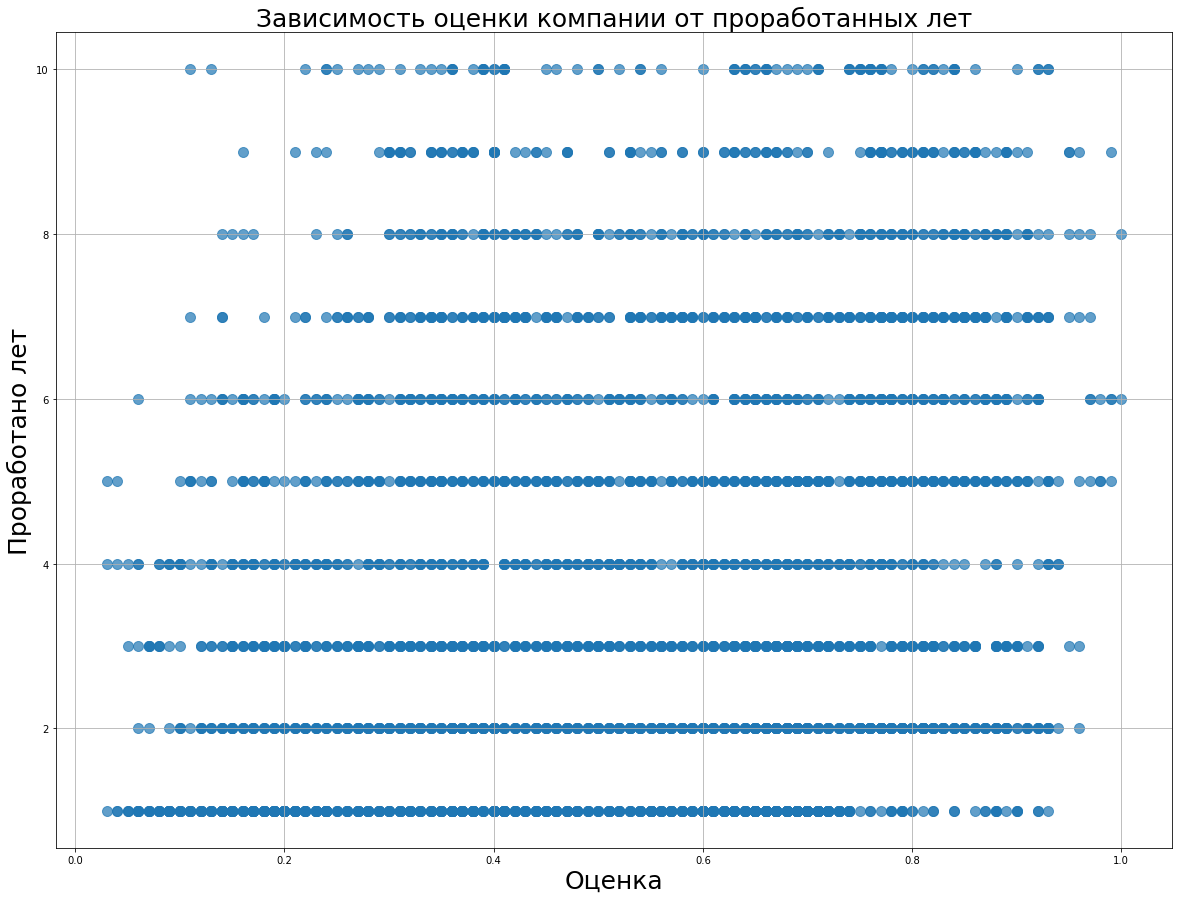

In [24]:
# Диаграмма рассеяния оценки компании от проработанных лет:
train_job_srate.plot.scatter(x='job_satisfaction_rate', y='employment_years', 
                        figsize=(20, 15), s=100, alpha=0.7, grid=True)

plt.title('Зависимость оценки компании от проработанных лет', fontsize=25)
plt.ylabel('Проработано лет', fontsize=25)
plt.xlabel('Оценка', fontsize=25)
plt.show()

In [25]:
train_job_srate['job_satisfaction_rate'].corr(train_job_srate['employment_years']) 

0.2082954848198832

Данные распределены более-менее равномерно, преобразовать с большей пользой их не получится.

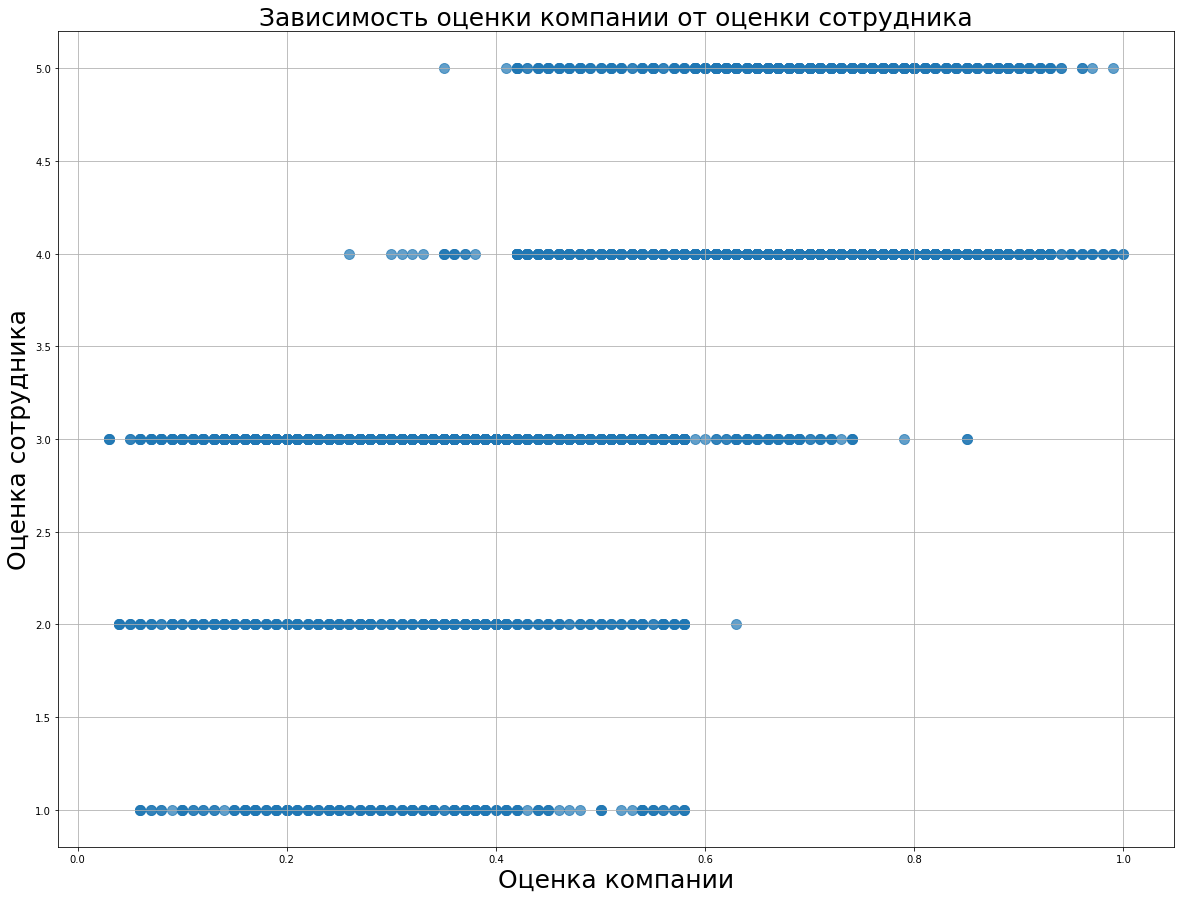

In [26]:
# Диаграмма рассеяния оценки компании от оценки сотрудника:
train_job_srate.plot.scatter(x='job_satisfaction_rate', y='supervisor_evaluation', 
                        figsize=(20, 15), s=100, alpha=0.7, grid=True)

plt.title('Зависимость оценки компании от оценки сотрудника', fontsize=25)
plt.ylabel('Оценка сотрудника', fontsize=25)
plt.xlabel('Оценка компании', fontsize=25)
plt.show()

In [27]:
train_job_srate['job_satisfaction_rate'].corr(train_job_srate['supervisor_evaluation']) 

0.6911760074348845

Видно, что практически все сотрудники, которых компания ценит (4+ по оценкам), так же отвечают ей взаимностью, за исключением нескольких человек. Имеет смысл сделать новый категориальный признак, в котором будет деление сотрудников по оценке от компании.

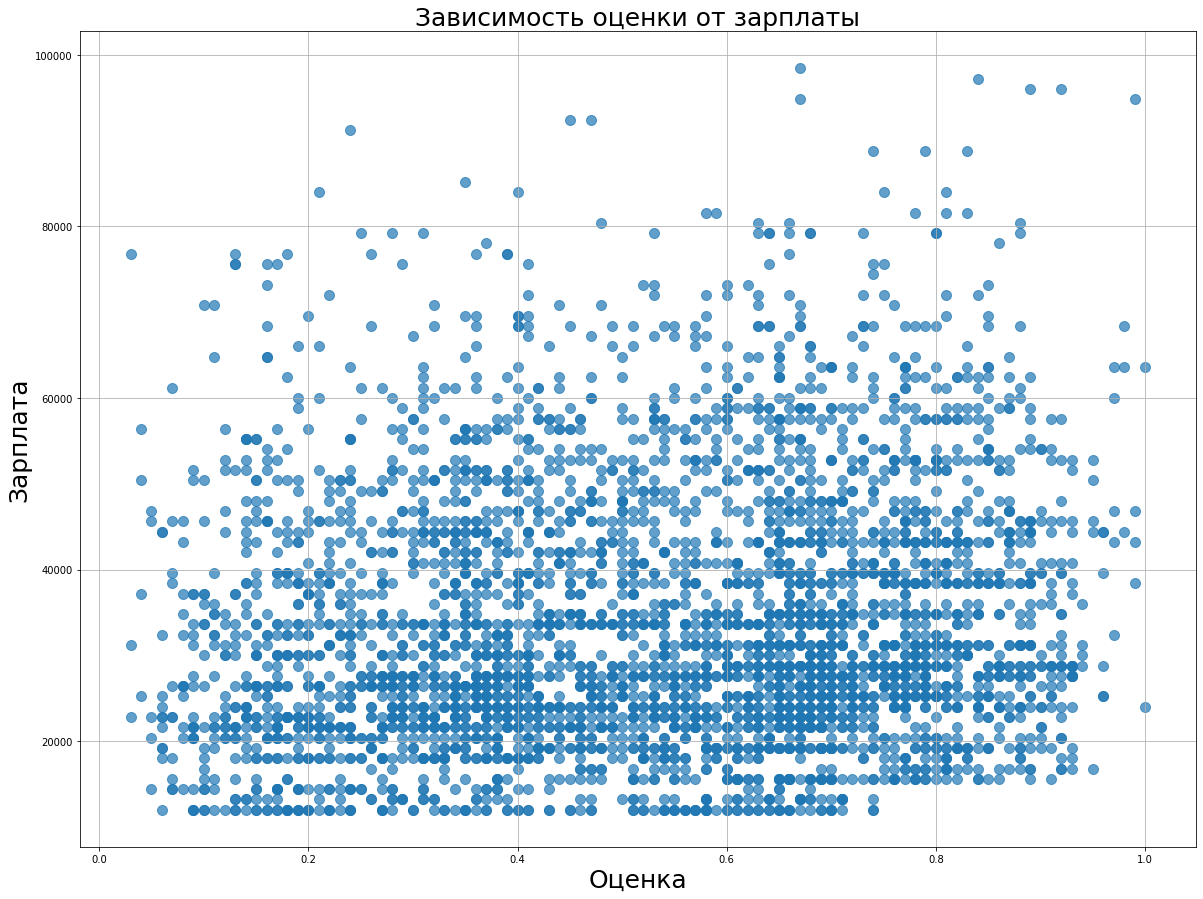

In [28]:
# Диаграмма рассеяния оценки от зарплаты:
train_job_srate.plot.scatter(x='job_satisfaction_rate', y='salary', 
                        figsize=(20, 15), s=100, alpha=0.7, grid=True)

plt.title('Зависимость оценки от зарплаты', fontsize=25)
plt.ylabel('Зарплата', fontsize=25)
plt.xlabel('Оценка', fontsize=25)
plt.show()

In [29]:
train_job_srate['job_satisfaction_rate'].corr(train_job_srate['salary']) 

0.11487994745687649

Добавим новые признаки в таблицу, у которых будет хорошая линейная корреляция с целевым признаком.

In [30]:
display(train_job_srate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [31]:
train_job_srate['salary_years'] = (train_job_srate['salary'] * train_job_srate['employment_years'])**(1/5)
print('Линейная корреляция:', train_job_srate['job_satisfaction_rate'].corr(train_job_srate['salary_years']))

Линейная корреляция: 0.21449609338430226


In [32]:
print('Корреляция с типом сервиса (коэффициент):', spearmanr(train_job_srate['job_satisfaction_rate'], train_job_srate['salary_years'])[0])
print('Корреляция с типом сервиса (p-значение):', spearmanr(train_job_srate['job_satisfaction_rate'], train_job_srate['salary_years'])[1])

Корреляция с типом сервиса (коэффициент): 0.21594347317912785
Корреляция с типом сервиса (p-значение): 2.0263722601402594e-43


Пойдёт, оставляем.

In [33]:
train_job_srate['emp_sup'] = (train_job_srate['employment_years'] * train_job_srate['supervisor_evaluation'])**(1/3)
print('Линейная корреляция:', train_job_srate['job_satisfaction_rate'].corr(train_job_srate['emp_sup']))

Линейная корреляция: 0.47087165700971045


In [34]:
print('Корреляция с типом сервиса (коэффициент):', spearmanr(train_job_srate['job_satisfaction_rate'], train_job_srate['emp_sup'])[0])
print('Корреляция с типом сервиса (p-значение):', spearmanr(train_job_srate['job_satisfaction_rate'], train_job_srate['emp_sup'])[1])

Корреляция с типом сервиса (коэффициент): 0.46406623036781836
Корреляция с типом сервиса (p-значение): 7.639030906119322e-213


Оставляем.

In [35]:
train_job_srate['sal_sup'] = (train_job_srate['salary'] * train_job_srate['supervisor_evaluation'])**(1/4)
print('Линейная корреляция:', train_job_srate['job_satisfaction_rate'].corr(train_job_srate['sal_sup']))

Линейная корреляция: 0.5007794014638094


In [36]:
print('Корреляция с типом сервиса (коэффициент):', spearmanr(train_job_srate['job_satisfaction_rate'], train_job_srate['sal_sup'])[0])
print('Корреляция с типом сервиса (p-значение):', spearmanr(train_job_srate['job_satisfaction_rate'], train_job_srate['sal_sup'])[1])

Корреляция с типом сервиса (коэффициент): 0.5009877736077911
Корреляция с типом сервиса (p-значение): 3.184453927430964e-253


Создадим дополнительный признак на основе качественных данных. Отберём сотрудников, которые ничем не выделились (ни повышений, ни нарушений).

In [37]:
def categ(a):
    if a == 'no':
        return 0
    elif a == 'yes':
        return 1
    
train_job_srate['last_year_violations_1'] = train_job_srate['last_year_violations'].apply(categ)
train_job_srate['last_year_promo_1'] = train_job_srate['last_year_promo'].apply(categ)

train_job_srate['category'] = train_job_srate['last_year_violations_1'] + train_job_srate['last_year_promo_1']
train_job_srate = train_job_srate.drop(['last_year_violations_1', 'last_year_promo_1'], axis=1)
display(train_job_srate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,salary_years,emp_sup,sal_sup,category
0,155278,sales,junior,medium,2,no,no,1,24000,0.58,8.63472,1.259921,12.44666,0
1,653870,hr,junior,high,2,no,no,5,38400,0.76,9.485762,2.154435,20.932703,0
2,184592,sales,junior,low,1,no,no,2,12000,0.11,6.543894,1.259921,12.44666,0
3,171431,technology,junior,low,4,no,no,2,18000,0.37,9.36411,2.0,13.774493,0
4,693419,hr,junior,medium,1,no,no,3,22800,0.20,7.44024,1.44225,16.172011,0


#### Вывод:
В ходе проведения исследовательского анализа были построены диграммы размаха для количественных данных и гистограммы для качественных.

Анализ графиков размаха дал следующий результат:
  - Все сотрудники работают в компании как минимум год, некоторые "мидлы" и "сеньоры" по 10 лет;
  - Чем выше уровень сотрудника, тем больше его зарплата;
  - Хоть и не на много, но "мидлы" оценивают работу лучше остальных.
  
Аномалий и явных выбросов обнаружено не было.

Анализ гистрограмм: 
  - В отеделе продаж задействовано больше всего сотрудников всех мастей. Распределение сеньоров по всем отделам примерно одинаково;
  - Значимо больше остальных заняты мидлы. Большинство сотрудников оценивают свою загруженность средне;
  - Повышений не было у большинства уже очень давно. Абсолютно все джуны не продвинулись за год по карьерной лестнице;
  - Джуны и мидлы нарушают примерно одинаково. Примерно 1/8 часть всех сотрудников где-то провинилась;
  - Подавляющее большинство сотрудников оценивается "средне" или "чуть выше среднего". Отличных сотрудников меньше, чем тех, у кого по рейтингу "1" или "2".
  
По оценке компании можно сказать следующее: 
  - большинство джунов ставят либо 0.7, либо 0.4; 
  - большинство мидлов ставят от 0.6 до 0.8;
  - сеньоры распределили оценки более-менее равномерно.
  
Можно выделить следующие порядковые признаки: загруженность сотрудника, уровень сотрудника. Количественные признаки в чистом виде: оценка сотрудника, уровень зарплаты, количество отработанных лет.

### Подготовка данных

Переходим к подготовке данных для машинного обучения. Осуществлять подготовку будем с помощью пайплайнов.

Пересоберём тестовые данные.

In [38]:
# пересборка тестовых данных:
test = test_features.merge(test_job_srate)
test_features = test.drop('job_satisfaction_rate', axis=1)
test_job_srate = test.job_satisfaction_rate

Добавим в test_features новые признаки.

In [39]:
test_features['salary_years'] = (test_features['salary'] * test_features['employment_years'])**(1/5)
test_features['emp_sup'] = (test_features['employment_years'] * test_features['supervisor_evaluation'])**(1/3)
test_features['sal_sup'] = (test_features['salary'] * test_features['supervisor_evaluation'])**(1/4)

test_features['last_year_violations_1'] = test_features['last_year_violations'].apply(categ)
test_features['last_year_promo_1'] = test_features['last_year_promo'].apply(categ)

test_features['category'] = test_features['last_year_violations_1'] + test_features['last_year_promo_1']
test_features = test_features.drop(['last_year_violations_1', 'last_year_promo_1'], axis=1)
display(test_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,salary_years,emp_sup,sal_sup,category
0,485046,marketing,junior,medium,2,no,no,5,28800,8.95539,2.154435,19.480075,0
1,686555,hr,junior,medium,1,no,no,4,30000,7.860031,1.587401,18.612097,0
2,467458,sales,middle,low,5,no,no,4,19200,9.918688,2.714418,16.647166,0
3,418655,sales,middle,low,6,no,no,4,19200,10.287042,2.884499,16.647166,0
4,789145,hr,middle,medium,5,no,no,5,40800,11.532568,2.924018,21.252378,0


Для упрощения работы во всех трёх таблицах вынесем "id" сотрудника в качестве индекса.

In [40]:
# Задаём новую индексацию:
train_job_srate = train_job_srate.set_index('id')
test_features = test_features.set_index('id')

In [41]:
# напомним, как выглядит основная таблица:
display(train_job_srate.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,salary_years,emp_sup,sal_sup,category
id,,,,,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58,8.63472,1.259921,12.44666,0
653870,hr,junior,high,2,no,no,5,38400,0.76,9.485762,2.154435,20.932703,0
184592,sales,junior,low,1,no,no,2,12000,0.11,6.543894,1.259921,12.44666,0
171431,technology,junior,low,4,no,no,2,18000,0.37,9.36411,2.0,13.774493,0
693419,hr,junior,medium,1,no,no,3,22800,0.20,7.44024,1.44225,16.172011,0


Целевой признак для предсказания - "job_satisfaction_rate". Вынесем его из основной таблицы.

In [42]:
# Отделение целевого признака:
X_train = train_job_srate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_srate.job_satisfaction_rate
X_test = test_features

Создаём сам пайплайн.

In [43]:
# Формируем константы:
RANDOM_STATE = 42

In [44]:
# Формируем списки столбцов для обработки:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
ord_col = ['level', 'workload']
num_col = ['employment_years', 'supervisor_evaluation', 'salary', 
           'salary_years', 'emp_sup', 'sal_sup', 'category']

In [45]:
# Для ohe_columns:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Для ord_columns: 
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                     ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# Собираем кусок пайплайна для обработки данных:
df_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', df_preprocessor),
    ('models', LinearRegression())
])

#### Вывод:
В ходе выполнения работы были преобразованы начальные таблицы (индексы заменены на id сотрудников), тренировочная выборка разделена, написан пайплайн, отвечающая за обработку данных.

### Обучение моделей

Продолжим писать код для пайплайна. Осталось создать кусок, который будет перебирать несколько моделей и искать лучшую из них.

In [46]:
# Перебора моделей:
param_grid_reg = [
    # Словарь для DecisionTreeRegressor():
    {
        'models': [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # Словарь для LinearRegression():
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

Пайплайны готовы. Осталось дать им на обработку наши данные. Но перед этим напишем код для новой метрики SMAPE.

In [47]:
# Метрика SMAPE:
def cal_smape(y_true, y_pred):
    return np.mean(((np.abs(y_true - y_pred)) / ((np.abs(y_true) + np.abs(y_pred))))*2)*100

smape = make_scorer(cal_smape, greater_is_better=False)

In [48]:
# Обучение модели:
grid_search = GridSearchCV(pipe_final, param_grid_reg, cv=2, scoring=smape, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Метрика SMAPE для лучшей модели:\n', grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

Метрика SMAPE для лучшей модели:
 -16.63051930654511

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleIm

Теперь сделаем предсказание на тестовых данных.

In [49]:
# Предсказание по тестовой выборке:
y_pred = grid_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {cal_smape(test_job_srate, y_pred)}')

Метрика SMAPE на тестовой выборке: 14.831385057001325


Результат удовлетворительный. Посмотрим на матрицу корреляции признаков.

In [50]:
# Объединим тренировочные данные:
X_train_p = pd.DataFrame(
    df_preprocessor.fit_transform(X_train),
    columns=df_preprocessor.get_feature_names_out())

X_train_matrix = X_train_p.assign(job_satisfaction_rate = y_train.values)

display(X_train_matrix.head())

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__salary_years,num__emp_sup,num__sal_sup,num__category,job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.111111,0.00,0.138889,0.227854,0.096840,0.123629,0.0,0.58
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.111111,1.00,0.305556,0.320599,0.430112,0.653407,0.0,0.76
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.25,0.000000,0.000000,0.096840,0.123629,0.0,0.11
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.25,0.069444,0.307341,0.372574,0.206525,0.0,0.37
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.50,0.125000,0.097682,0.164771,0.356200,0.0,0.20


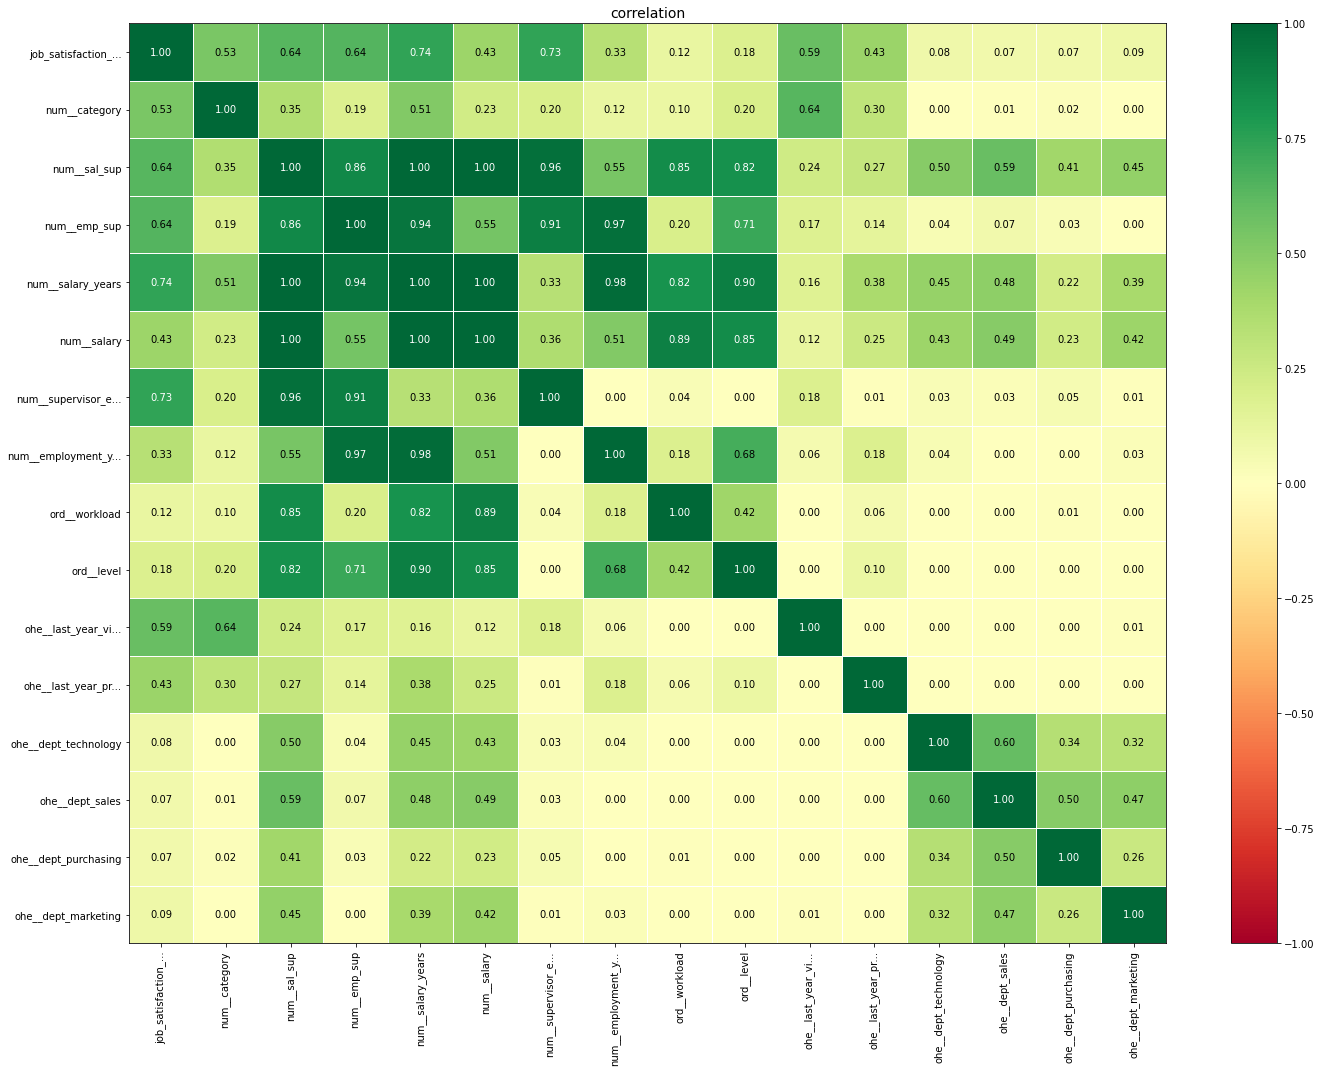

In [51]:
# Построение матрицы корреляции:
interval_cols = ['level']
phik_overview = X_train_matrix.phik_matrix(interval_cols = interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(20, 15))

Присутствует мультиколлинеарность, однако качество модели достаточно высоко, дополнительная обработка не требуется.

Результат по метрике удовлетворяет нашему условия (<15). Обучим лучшую модель.

In [52]:
# Обучение лучшей модели:
best_reg_model = DecisionTreeRegressor(max_depth=14, max_features=10, min_samples_split=13, random_state=42)
best_reg_model.fit(X_train_p, y_train)

DecisionTreeRegressor(max_depth=14, max_features=10, min_samples_split=13,
                      random_state=42)

#### Вывод:
В ходе выполнения данного пункта работы был выполнен подбор лучшей модели линейной регрессии, а также произведено её обучение.

Получены необходимые данные по оценке компании сотрудниками.

### Оформление выводов

##### Отчёт о проделанной работе:

После распаковки файлов сразу видим пару пропущенных значений в первой и второй таблицах. Благо, их немного. С типами данных нигде проблем нет. Названия столбцов записаны приемлемо. Можем переходить к предобработке данных.

В ходе предобработки данных была выполнена проверка на дубликаты, на корректность заполнения таблиц, а также заполнены немногочисленные пропуски.

В ходе проведения исследовательского анализа были построены диграммы размаха для количественных данных и гистограммы для качественных.

Анализ графиков размаха дал следующий результат:
  - Все сотрудники работают в компании как минимум год, некоторые "мидлы" и "сеньоры" по 10 лет;
  - Чем выше уровень сотрудника, тем больше его зарплата;
  - Хоть и не на много, но "мидлы" оценивают работу лучше остальных.
  
Аномалий и явных выбросов обнаружено не было.

Анализ гистрограмм: 
  - В отеделе продаж задействовано больше всего сотрудников всех мастей. Распределение сеньоров по всем отделам примерно одинаково;
  - Значимо больше остальных заняты мидлы. Большинство сотрудников оценивают свою загруженность средне;
  - Повышений не было у большинства уже очень давно. Абсолютно все джуны не продвинулись за год по карьерной лестнице;
  - Джуны и мидлы нарушают примерно одинаково. Примерно 1/8 часть всех сотрудников где-то провинилась;
  - Подавляющее большинство сотрудников оценивается "средне" или "чуть выше среднего". Отличных сотрудников меньше, чем тех, у кого по рейтингу "1" или "2".
  
По оценке компании можно сказать следующее: 
  - большинство джунов ставят либо 0.7, либо 0.4; 
  - большинство мидлов ставят от 0.6 до 0.8;
  - сеньоры распределили оценки более-менее равномерно.
  
Можно выделить следующие порядковые признаки: загруженность сотрудника, уровень сотрудника. Количественные признаки в чистом виде: оценка сотрудника, уровень зарплаты, количество отработанных лет.

В ходе выполнения работы были преобразованы начальные таблицы (индексы заменены на id сотрудников), тренировочная выборка разделена, написан пайплайн, отвечающая за обработку данных.

В результате выбрана лучшая модель линейной регрессии: DecisionTreeRegressor(max_depth=14, max_features=10, min_samples_split=13, random_state=42). С помощью неё совершены предсказания оценки компании сотрудниками.
   
##### Итог и рекомендации:
Работа выполнена в полном объёме, обученная модель МО имеет достаточно высокую метрику (SMAPE < 15) и в дополнительных данных не нуждается. Дополнительные исследования в рамках этой задачи не понадобятся.

## Задача №2: "Предсказание увольнения сотрудника из компании"

### Загрузка данных

Загружаем оставшиеся таблицы и выводим общую информацию о них. Таблицу "test_features" используем из предыдущего пункта.

In [53]:
# Загрузка данных:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_quit = pd.read_csv('/datasets/test_target_quit.csv')

display(train_quit.head())
train_quit.info()
display(test_quit.head())
test_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


#### Вывод:
Никаких видимых недочётов в новых таблицах не наблюдается. Переходим к предобработке.

### Предобработка данных

Произведём проверку на дубликаты.

In [54]:
# Проверка на явные дубликаты:
print(train_quit.duplicated().sum())
print(test_quit.duplicated().sum())

0
0


In [55]:
# Проверка на неявные дубликаты:
print(train_quit['id'].duplicated().sum())
print(test_quit['id'].duplicated().sum())

0
0


Переходим к проверке на корректность заполнения таблицы.

In [56]:
# Проверяем корректную запись данных таблицы:
print(train_quit['dept'].unique())
print(train_quit['level'].unique())
print(train_quit['workload'].unique())
print(train_quit['last_year_promo'].unique())
print(train_quit['last_year_violations'].unique())
print(train_quit['quit'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


Сбоев не обнаружено.

#### Вывод:
В ходе предобработки данных проверили новые таблицы на дубликаты и корректность записи данных. Никаких сбоев не обнаружено, можно переходить к исследовательскому анализу.

### Добавление нового входного признака

Из задачи №1 с помощью обученной модели предскажем оценку компании от работников. Добавим новый признак в исходную таблицу.

In [57]:
# Добавляем новые столбцы из первой задачи:
train_quit['salary_years'] = (train_quit['salary'] * train_quit['employment_years'])**(1/5)
train_quit['emp_sup'] = (train_quit['employment_years'] * train_quit['supervisor_evaluation'])**(1/3)
train_quit['sal_sup'] = (train_quit['salary'] * train_quit['supervisor_evaluation'])**(1/4)

train_quit['last_year_violations_1'] = train_quit['last_year_violations'].apply(categ)
train_quit['last_year_promo_1'] = train_quit['last_year_promo'].apply(categ)

train_quit['category'] = train_quit['last_year_violations_1'] + train_quit['last_year_promo_1']
train_quit = train_quit.drop(['last_year_violations_1', 'last_year_promo_1'], axis=1)
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,salary_years,emp_sup,sal_sup,category
0,723290,sales,middle,high,2,no,no,4,54000,no,10.155113,2.000000,21.558247,0
1,814010,sales,junior,medium,2,no,no,4,27600,no,8.879486,2.000000,18.228136,0
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,11.321464,1.709976,13.887873,0
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,8.634720,1.817121,16.380725,1
4,910140,marketing,junior,medium,2,no,no,5,25200,no,8.719390,2.154435,18.840509,0


In [58]:
# Предсказание оценки компании:
X_quit = pd.DataFrame(
    df_preprocessor.transform(train_quit.drop(['id', 'quit'], axis=1)),
    columns=df_preprocessor.get_feature_names_out())
display(X_quit.head())

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__salary_years,num__emp_sup,num__sal_sup,num__category
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.111111,0.75,0.486111,0.393543,0.372574,0.692459,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.111111,0.75,0.180556,0.254528,0.372574,0.484563,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.444444,0.00,0.291667,0.520650,0.264518,0.213603,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.111111,0.50,0.138889,0.227854,0.304438,0.369230,0.5
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.111111,1.00,0.152778,0.237081,0.430112,0.522793,0.0


In [59]:
# Добавление нового столбца:
train_quit['job_satisfaction_rate'] = best_reg_model.predict(X_quit)
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,salary_years,emp_sup,sal_sup,category,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,10.155113,2.000000,21.558247,0,0.626364
1,814010,sales,junior,medium,2,no,no,4,27600,no,8.879486,2.000000,18.228136,0,0.828293
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,11.321464,1.709976,13.887873,0,0.271667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,8.634720,1.817121,16.380725,1,0.309167
4,910140,marketing,junior,medium,2,no,no,5,25200,no,8.719390,2.154435,18.840509,0,0.828293


#### Вывод:
С помощью лучшей модели из первой задачи предсказаны оценки компании от сотрудников. Теперь данные готовы к полному анализу.

### Исследовательский анализ данных

Основные закономерности мы уже рассмотрели в задаче №1. Сейчас нам интересен новый признак: уволился ли сотрудник. В соответствии с ним разберём остальные признаки и найдём зависимости.

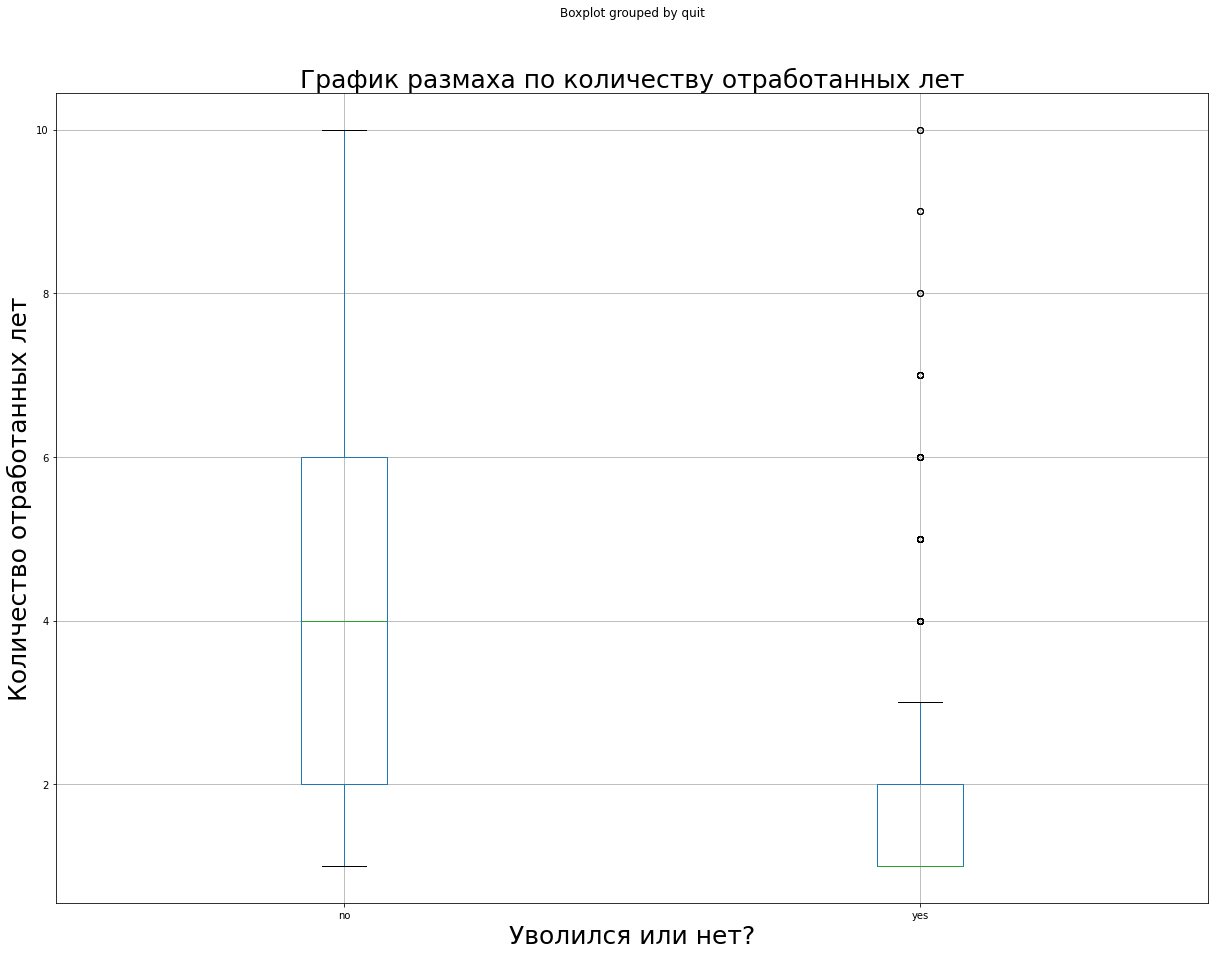

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,2872.0,4.430710,2.544635,1.0,2.0,4.0,6.0,10.0
yes,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0


In [60]:
# График размаха по количеству отработанных лет:
train_quit.boxplot(column='employment_years', by='quit', figsize=(20, 15))
plt.title('График размаха по количеству отработанных лет', fontsize=25)
plt.ylabel('Количество отработанных лет', fontsize=25)
plt.xlabel('Уволился или нет?', fontsize=25)
plt.show()

train_quit.groupby('quit')['employment_years'].describe()

В основном увольняются новички, предельный срок - 3 года. Конечно, есть и единичные случаи с более длительным стажем.

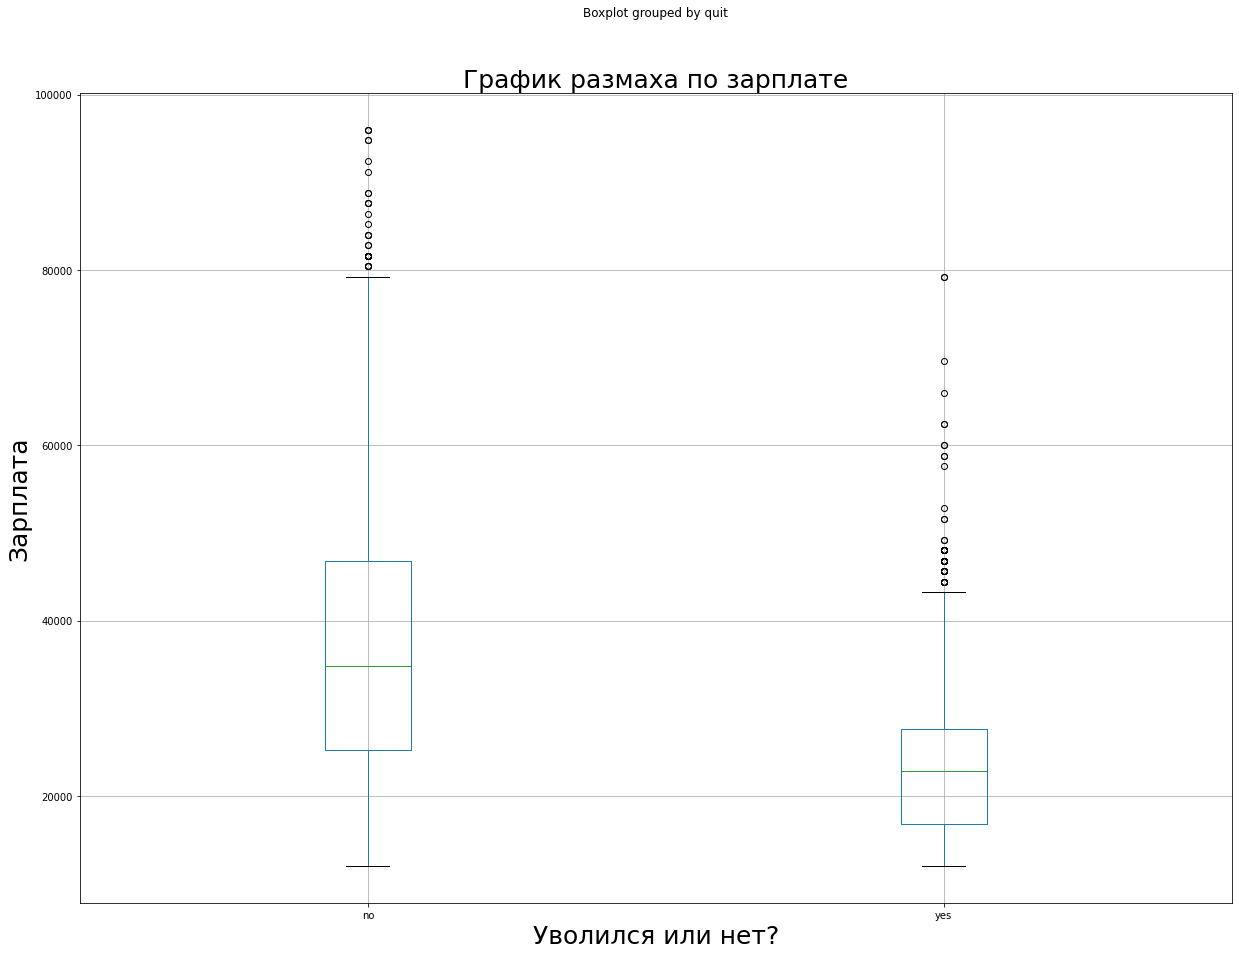

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,2872.0,37702.228412,15218.977339,12000.0,25200.0,34800.0,46800.0,96000.0
yes,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


In [61]:
# График размаха по зарплате:
train_quit.boxplot(column='salary', by='quit', figsize=(20, 15))
plt.title('График размаха по зарплате', fontsize=25)
plt.ylabel('Зарплата', fontsize=25)
plt.xlabel('Уволился или нет?', fontsize=25)
plt.show()

train_quit.groupby('quit')['salary'].describe()

Сразу видно, что зарплата выше 80000 считается престижной, ни один человек с этой суммой не уволнялся.

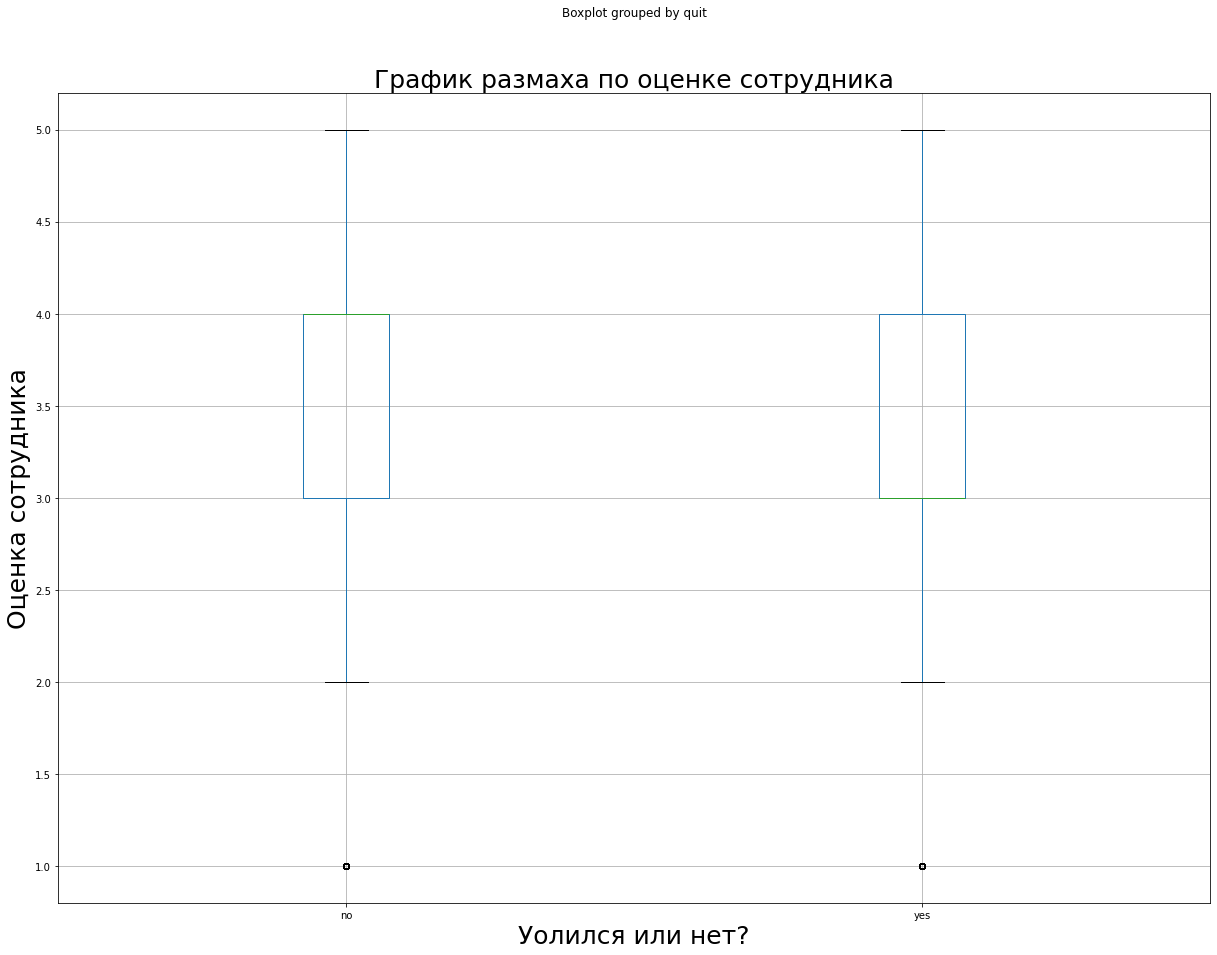

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,2872.0,3.643106,0.965295,1.0,3.0,4.0,4.0,5.0
yes,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0


In [62]:
# График размаха по количеству отработанных лет:
train_quit.boxplot(column='supervisor_evaluation', by='quit', figsize=(20, 15))
plt.title('График размаха по оценке сотрудника', fontsize=25)
plt.ylabel('Оценка сотрудника', fontsize=25)
plt.xlabel('Уолился или нет?', fontsize=25)
plt.show()

train_quit.groupby('quit')['supervisor_evaluation'].describe()

Ничего примечательного.

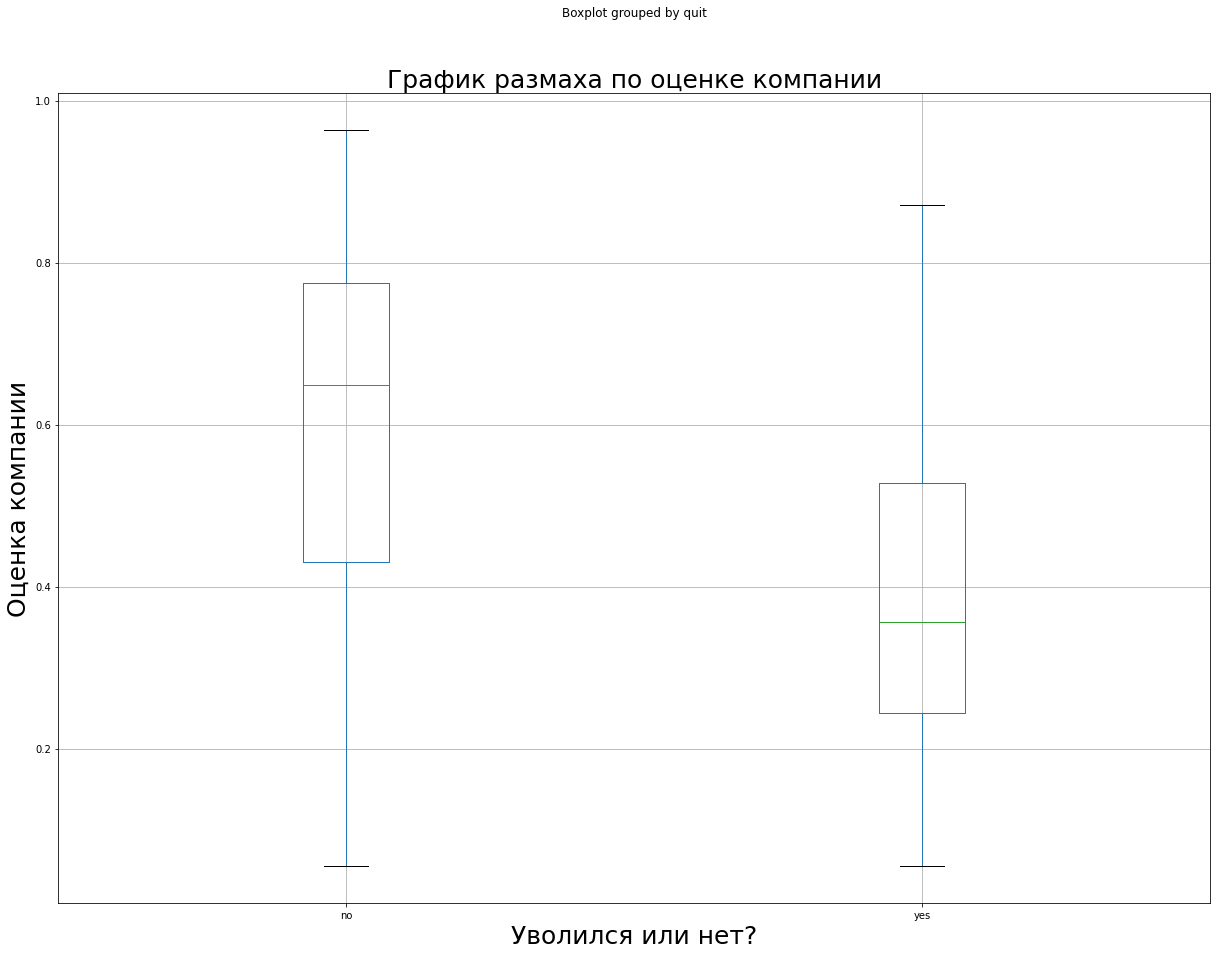

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,2872.0,0.590059,0.204069,0.055,0.430000,0.649535,0.774444,0.964286
yes,1128.0,0.401794,0.187544,0.055,0.243333,0.355714,0.527500,0.870833


In [63]:
# График размаха по оценке компании:
train_quit.boxplot(column='job_satisfaction_rate', by='quit', figsize=(20, 15))
plt.title('График размаха по оценке компании', fontsize=25)
plt.ylabel('Оценка компании', fontsize=25)
plt.xlabel('Уволился или нет?', fontsize=25)
plt.show()

train_quit.groupby('quit')['job_satisfaction_rate'].describe()

Те, кто уволился, оценивали компанию максимум на 0.75, но и не ниже 0.15. Странный разброс.

##### Промежуточный вывод:
По графикам рассеяния можно сделать следующие выводы: 
  - В основном увольняются новички, предельный срок - 3 года. Конечно, есть и единичные случаи с более длительным стажем.
  - Сразу видно, что зарплата выше 80000 считается престижной, ни один человек с этой суммой не уволнялся.
  - Те, кто уволился, оценивали компанию максимум на 0.75, но и не ниже 0.15.

Переходим к анализу гистограмм.

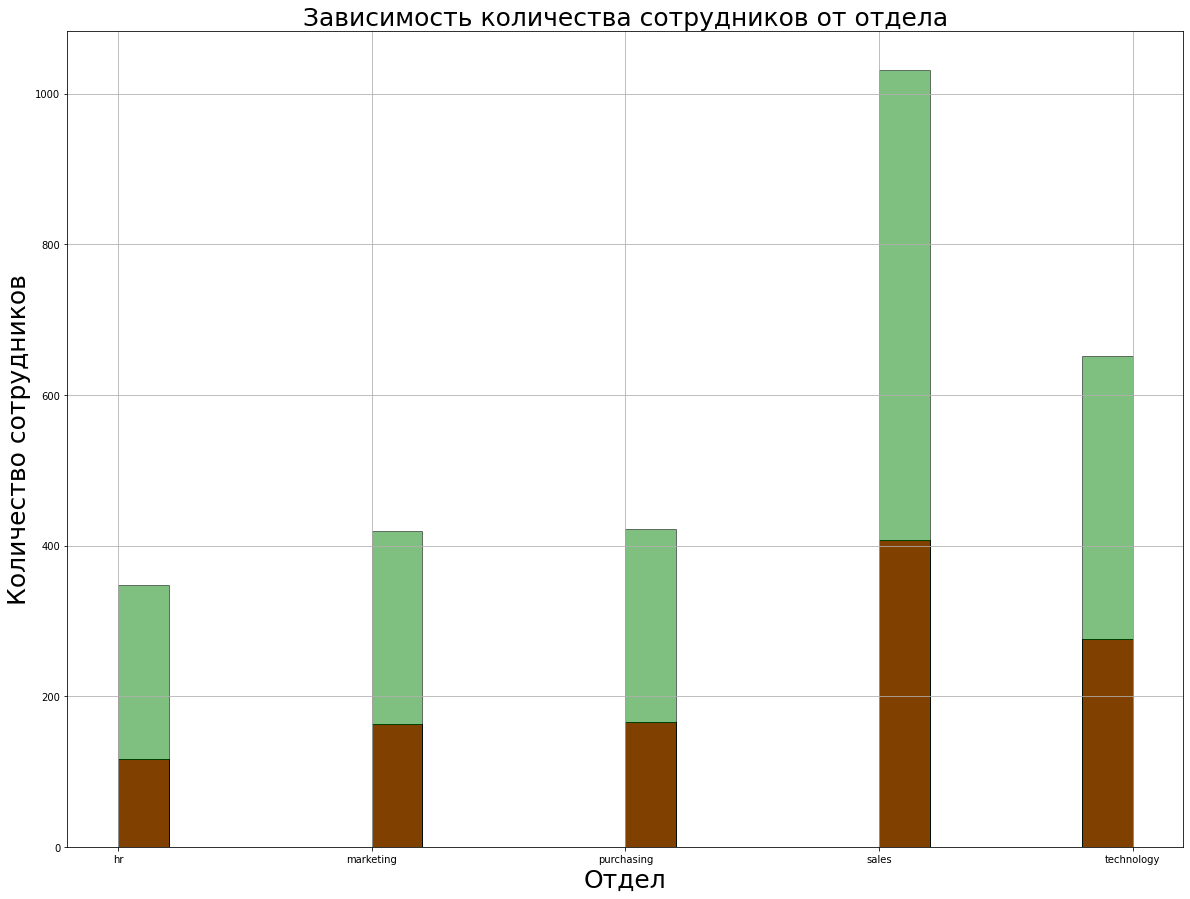

In [64]:
#Гистограмма по отделам:
train_quit[train_quit['quit']=='yes'].sort_values(by='dept', ascending=True)['dept'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1, 
                                                                      color='red')
train_quit[train_quit['quit']=='no'].sort_values(by='dept', ascending=True)['dept'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
plt.title('Зависимость количества сотрудников от отдела', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Отдел', fontsize=25)
plt.show()


Во всех отделах уволилась одинаковая часть сотрудников.

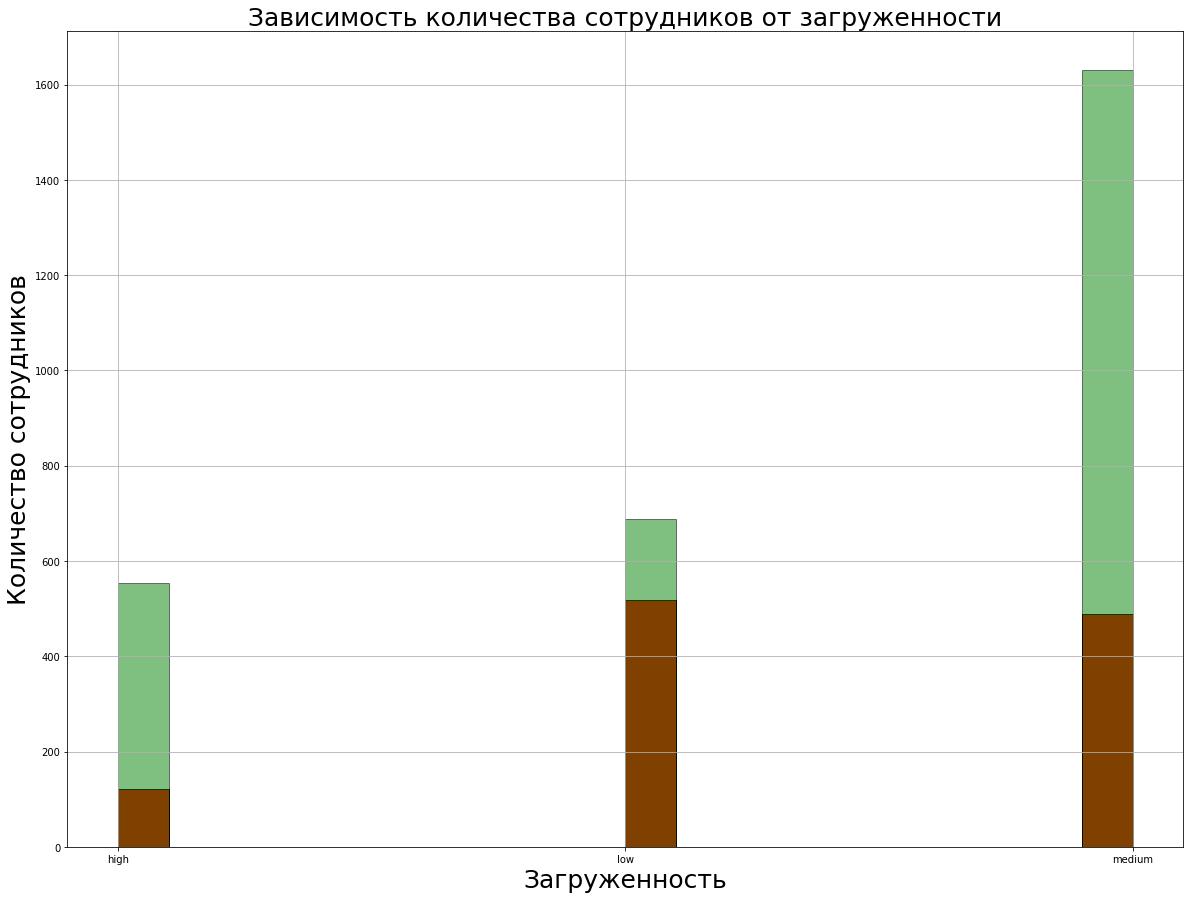

In [65]:
#Гистограмма по загруженности:
train_quit[train_quit['quit']=='yes'].sort_values(by='workload', ascending=True)['workload'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1, 
                                                                      color='red')
train_quit[train_quit['quit']=='no'].sort_values(by='workload', ascending=True)['workload'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
plt.title('Зависимость количества сотрудников от загруженности', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Загруженность', fontsize=25)
plt.show()

Больше всего уволилось сотрудников с низкой нагрузкой. Хотят работать, а им не дают.

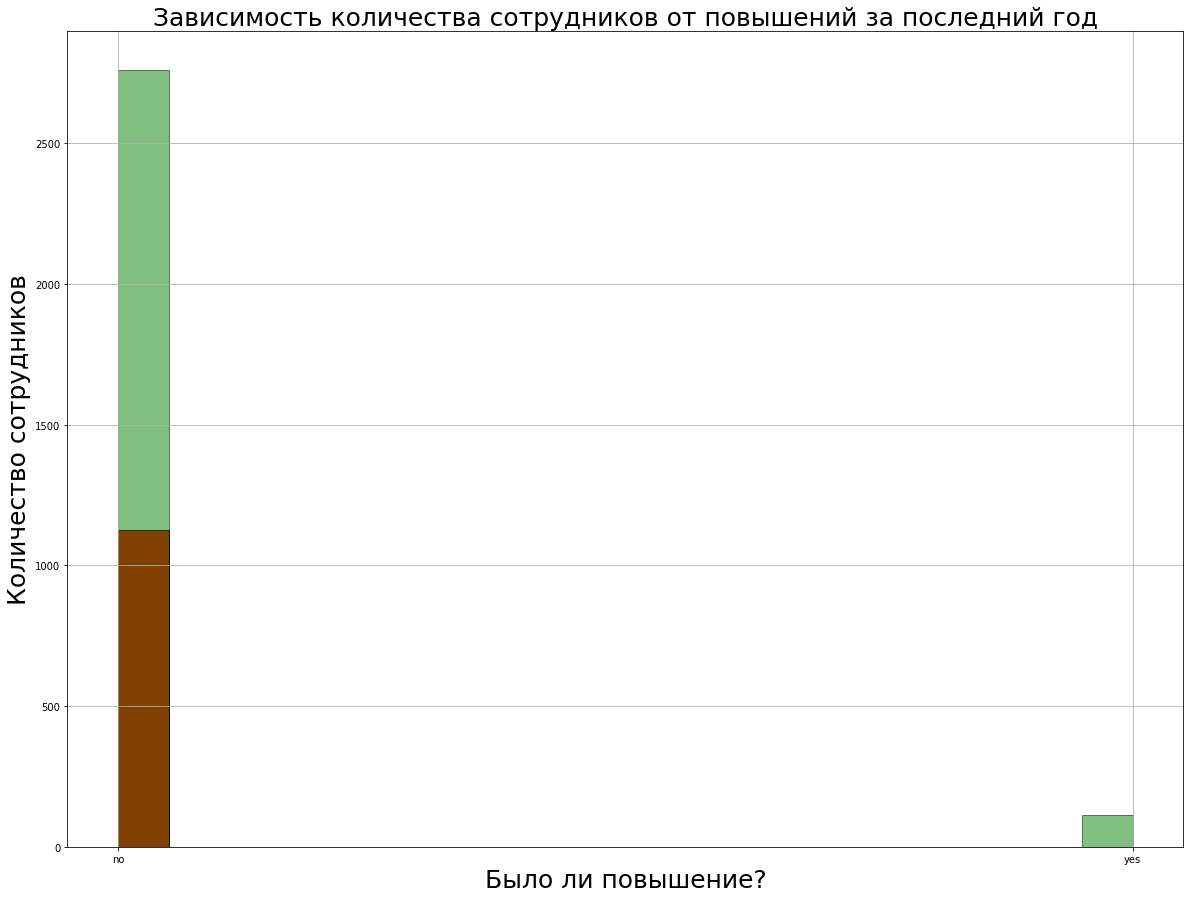

In [66]:
#Гистограмма по повышениям:
train_quit[train_quit['quit']=='yes'].sort_values(by='last_year_promo', ascending=True)['last_year_promo'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1, 
                                                                      color='red')
train_quit[train_quit['quit']=='no'].sort_values(by='last_year_promo', ascending=True)['last_year_promo'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
plt.title('Зависимость количества сотрудников от повышений за последний год', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Было ли повышение?', fontsize=25)
plt.show()

Увольнялись только те, кого не повышали.

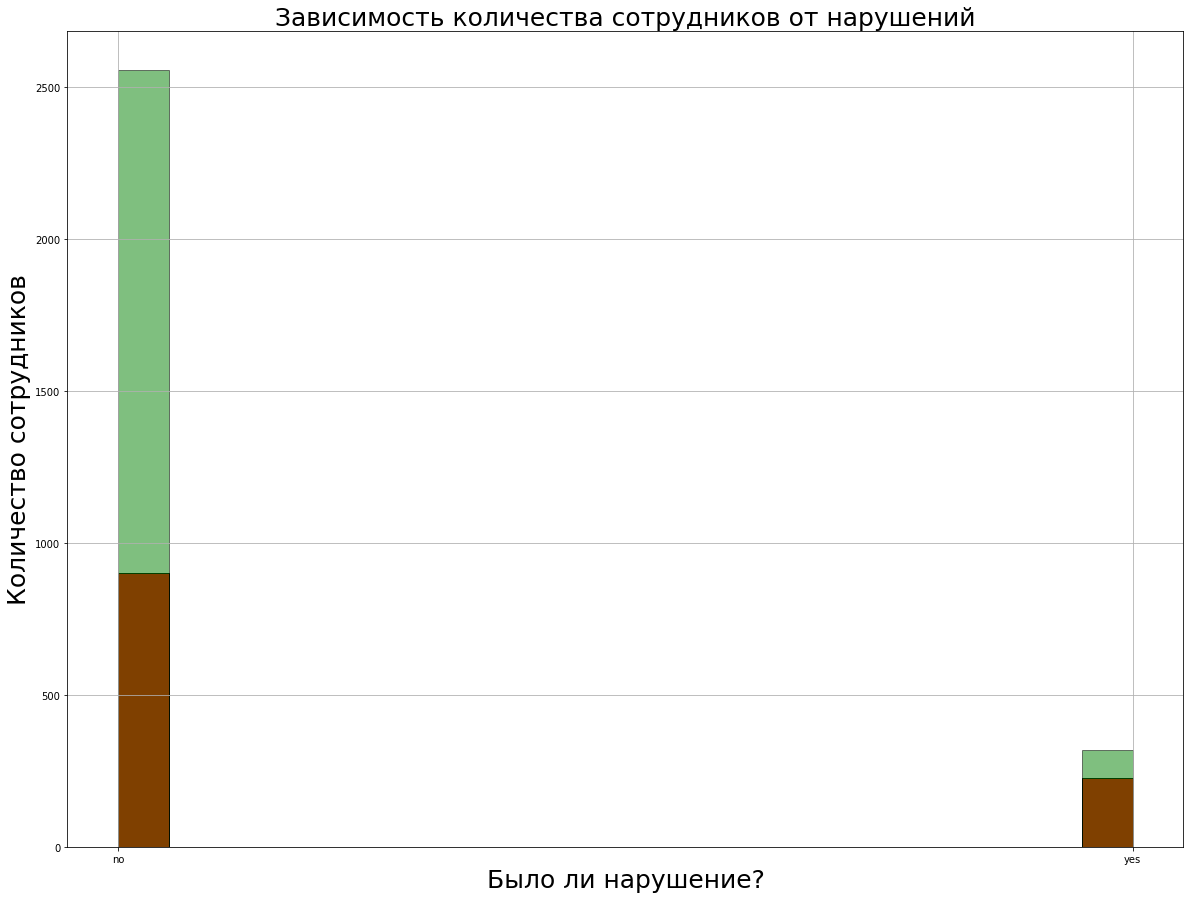

In [67]:
#Гистограмма по загруженности:
train_quit[train_quit['quit']=='yes'].sort_values(by='last_year_violations', ascending=True)['last_year_violations'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1, 
                                                                      color='red')
train_quit[train_quit['quit']=='no'].sort_values(by='last_year_violations', ascending=True)['last_year_violations'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')

plt.title('Зависимость количества сотрудников от нарушений', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Было ли нарушение?', fontsize=25)
plt.show()

Практически 40% тех, кто нарушил, уволилось.

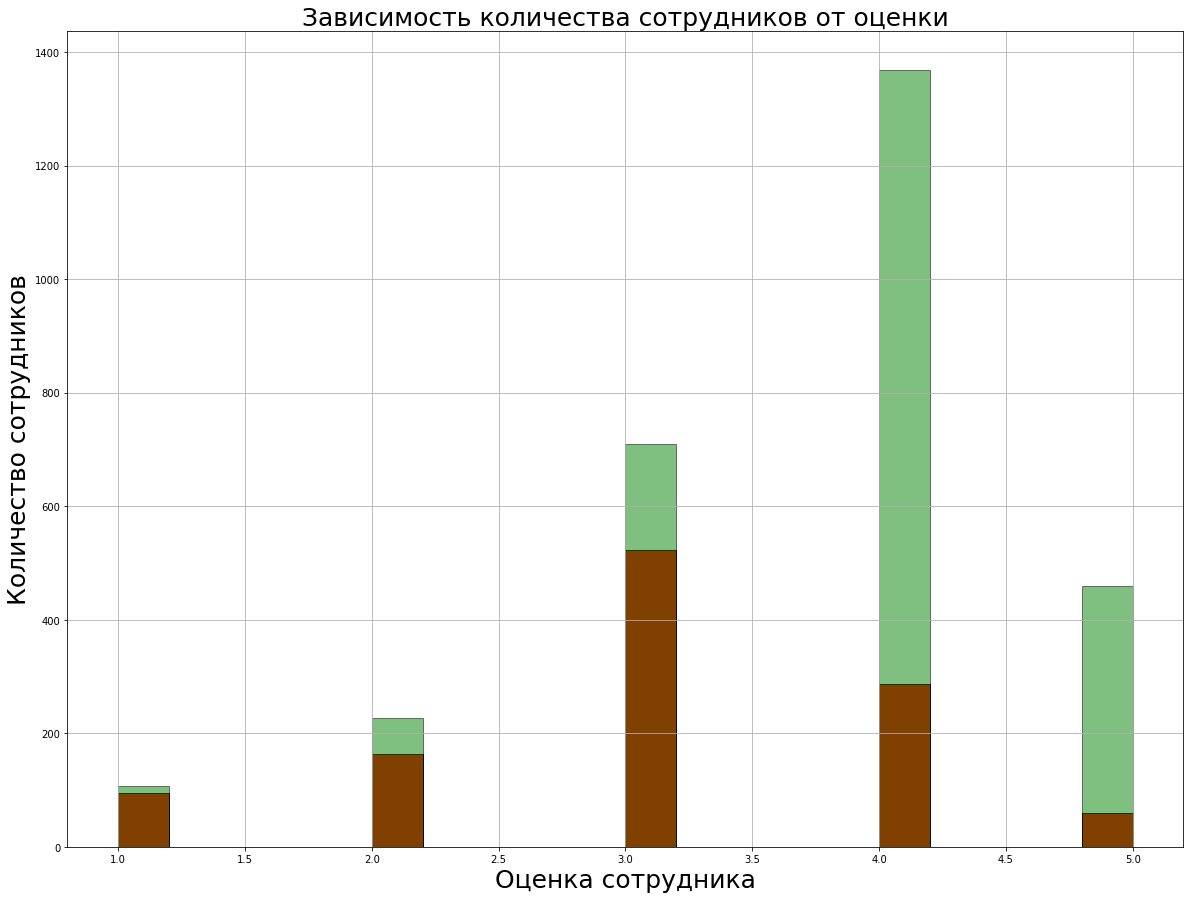

In [68]:
#Гистограмма по оценке сотрудника:
train_quit[train_quit['quit']=='yes'].sort_values(by='supervisor_evaluation', ascending=True)['supervisor_evaluation'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1, 
                                                                      color='red')
train_quit[train_quit['quit']=='no'].sort_values(by='supervisor_evaluation', ascending=True)['supervisor_evaluation'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')

plt.title('Зависимость количества сотрудников от оценки', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Оценка сотрудника', fontsize=25)
plt.show()

Больше всего уволилось тех, кого оценили на троечку.

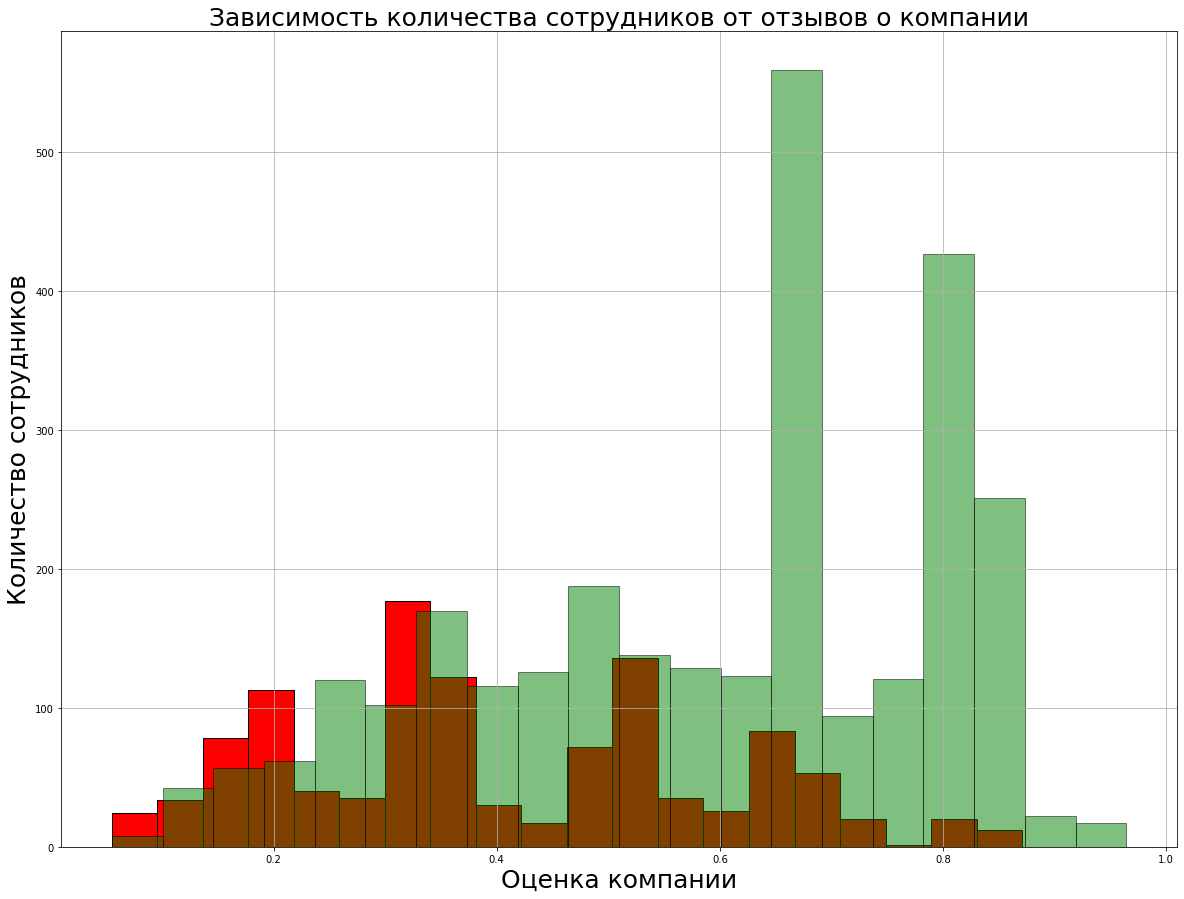

In [69]:
#Гистограмма по оценке компании:
train_quit[train_quit['quit']=='yes'].sort_values(by='job_satisfaction_rate', ascending=True)['job_satisfaction_rate'].hist(
                                                                      bins=20, 
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 1, 
                                                                      color='red')
train_quit[train_quit['quit']=='no'].sort_values(by='job_satisfaction_rate', ascending=True)['job_satisfaction_rate'].hist(
                                                                      bins=20,
                                                                      figsize=(20,15), 
                                                                      edgecolor=(0, 0, 0), 
                                                                      alpha = 0.5, 
                                                                      color='green')
plt.title('Зависимость количества сотрудников от отзывов о компании', fontsize=25)
plt.ylabel('Количество сотрудников', fontsize=25)
plt.xlabel('Оценка компании', fontsize=25)
plt.show()

Увольнялись те, кто оценивал компанию чуть выше 0.3. А вот остались как раз люди с оценкой 0.65.

Для составления портрета уволившегося сотрудника посчитаем их доли в зависимости от отдела работы.

In [70]:
# Доли сотрудников:
hr = (train_quit[(train_quit['quit']=='yes') & (train_quit['dept']=='hr')]['dept'].count() / 
                                        train_quit[train_quit['dept']=='hr']['dept'].count())
mr = (train_quit[(train_quit['quit']=='yes') & (train_quit['dept']=='marketing')]['dept'].count() / 
                                        train_quit[train_quit['dept']=='marketing']['dept'].count())
pr = (train_quit[(train_quit['quit']=='yes') & (train_quit['dept']=='purchasing')]['dept'].count() / 
                                        train_quit[train_quit['dept']=='purchasing']['dept'].count())
sl = (train_quit[(train_quit['quit']=='yes') & (train_quit['dept']=='sales')]['dept'].count() / 
                                        train_quit[train_quit['dept']=='sales']['dept'].count())
th = (train_quit[(train_quit['quit']=='yes') & (train_quit['dept']=='technology')]['dept'].count() / 
                                        train_quit[train_quit['dept']=='technology']['dept'].count())
print(f'Уволилось из HR: {hr:0.2}')
print(f'Уволилось из маркетинга: {mr:0.2}')
print(f'Уволилось из покупок: {pr:0.2}')
print(f'Уволилось из продаж: {sl:0.2}')
print(f'Уволилось из технологического: {th:0.2}')

Уволилось из HR: 0.25
Уволилось из маркетинга: 0.28
Уволилось из покупок: 0.28
Уволилось из продаж: 0.28
Уволилось из технологического: 0.3


#### Вывод:
По графикам рассеяния можно сделать следующие выводы: 
  - В основном увольняются новички, предельный срок - 3 года. Конечно, есть и единичные случаи с более длительным стажем.
  - Сразу видно, что зарплата выше 80000 считается престижной, ни один человек с этой суммой не уволнялся.
  - Те, кто уволился, оценивали компанию максимум на 0.75, но и не ниже 0.15.
  
По анализу гистограмм можно сказать следующее:
  - Во всех отделах уволилась одинаковая часть сотрудников.
  - Больше всего уволилось сотрудников с низкой нагрузкой. Хотят работать, а им не дают.
  - Увольнялись только те, кого не повышали.
  - Практически 40% тех, кто нарушил, уволилось.
  - Больше всего уволилось тех, кого оценили на троечку.
  - Увольнялись те, кто оценивал компанию чуть выше 0.3. А вот остались как раз люди с оценкой 0.65.
  
Портрет уволившегося сотрудника: работал в компании меньше 3 лет, получал зарплату меньше 80000, оценивал компанию максимум на 0.75, был в отделе продаж, с низкой трудовой нагрузкой, не получал повышения в течение года, руковоство несильно ценило. По всем отделам количество уволившихся сотрудников примерно одинаково: от 25% до 30% (больше всего ушло из технологического, меньше всего - из HR).

### Подготовка данных

Составим пайплайн для подготовки данных.

Вложим значения рейтинга в тестовую таблицу.

In [71]:
test_feat_quit = test.merge(test_quit)
display(test_feat_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [72]:
# Делим выборку:
test_features_quit = test_feat_quit.drop('quit', axis=1)
test_quit = test_feat_quit.quit
print(test_quit)

0        no
1        no
2        no
3        no
4        no
       ... 
1995    yes
1996    yes
1997    yes
1998     no
1999     no
Name: quit, Length: 2000, dtype: object


Добавляем новые столбцы из первой задачи.

In [73]:
# Добавляем новые столбцы:
test_features_quit['salary_years'] = (test_features_quit['salary'] * test_features_quit['employment_years'])**(1/5)
test_features_quit['emp_sup'] = (test_features_quit['employment_years'] * test_features_quit['supervisor_evaluation'])**(1/3)
test_features_quit['sal_sup'] = (test_features_quit['salary'] * test_features_quit['supervisor_evaluation'])**(1/4)

test_features_quit['last_year_violations_1'] = test_features_quit['last_year_violations'].apply(categ)
test_features_quit['last_year_promo_1'] = test_features_quit['last_year_promo'].apply(categ)

test_features_quit['category'] = test_features_quit['last_year_violations_1'] + test_features_quit['last_year_promo_1']
test_features_quit = test_features_quit.drop(['last_year_violations_1', 'last_year_promo_1'], axis=1)
display(test_features_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,salary_years,emp_sup,sal_sup,category
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,8.95539,2.154435,19.480075,0
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,7.860031,1.587401,18.612097,0
2,467458,sales,middle,low,5,no,no,4,19200,0.64,9.918688,2.714418,16.647166,0
3,418655,sales,middle,low,6,no,no,4,19200,0.60,10.287042,2.884499,16.647166,0
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,11.532568,2.924018,21.252378,0


In [74]:
# Меняем индексы таблиц на "id":
train_quit = train_quit.set_index('id')
test_features_quit = test_features_quit.set_index('id')
display(test_features_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,salary_years,emp_sup,sal_sup,category
id,,,,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,8.95539,2.154435,19.480075,0
686555,hr,junior,medium,1,no,no,4,30000,0.72,7.860031,1.587401,18.612097,0
467458,sales,middle,low,5,no,no,4,19200,0.64,9.918688,2.714418,16.647166,0
418655,sales,middle,low,6,no,no,4,19200,0.60,10.287042,2.884499,16.647166,0
789145,hr,middle,medium,5,no,no,5,40800,0.75,11.532568,2.924018,21.252378,0


In [75]:
# Напомним, как выглядит тренировочная выборка:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,salary_years,emp_sup,sal_sup,category,job_satisfaction_rate
id,,,,,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,10.155113,2.000000,21.558247,0,0.626364
814010,sales,junior,medium,2,no,no,4,27600,no,8.879486,2.000000,18.228136,0,0.828293
155091,purchasing,middle,medium,5,no,no,1,37200,no,11.321464,1.709976,13.887873,0,0.271667
257132,sales,junior,medium,2,no,yes,3,24000,yes,8.634720,1.817121,16.380725,1,0.309167
910140,marketing,junior,medium,2,no,no,5,25200,no,8.719390,2.154435,18.840509,0,0.828293


In [76]:
# Отделение целевого признака:
X_train_quit = train_quit.drop('quit', axis=1)
y_train_quit = train_quit.quit
display(X_train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,salary_years,emp_sup,sal_sup,category,job_satisfaction_rate
id,,,,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,10.155113,2.000000,21.558247,0,0.626364
814010,sales,junior,medium,2,no,no,4,27600,8.879486,2.000000,18.228136,0,0.828293
155091,purchasing,middle,medium,5,no,no,1,37200,11.321464,1.709976,13.887873,0,0.271667
257132,sales,junior,medium,2,no,yes,3,24000,8.634720,1.817121,16.380725,1,0.309167
910140,marketing,junior,medium,2,no,no,5,25200,8.719390,2.154435,18.840509,0,0.828293


In [77]:
# Сразу закодируем целевой признак:
label = LabelEncoder()
y_train_quit = label.fit_transform(y_train_quit.values.ravel())
y_test_quit = label.transform(test_quit.values.ravel())
print(y_train_quit)

[0 0 0 ... 1 0 1]


In [78]:
# Формируем списки столбцов для обработки:
ohe_col_quit = ['dept', 'last_year_promo', 'last_year_violations']
ord_col_quit = ['level', 'workload']
num_col_quit = ['employment_years', 'supervisor_evaluation', 'salary', 'salary_years', 
                'emp_sup', 'sal_sup', 'category', 'job_satisfaction_rate']

In [79]:
# Для ohe_columns:
ohe_pipe_quit = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Для ord_columns: 
ord_pipe_quit = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                     ['junior', 'middle', 'sinior'],
                     ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])


# Собираем кусок пайплайна для обработки данных:
df_preprocessor_quit = ColumnTransformer(
    [('ohe', ohe_pipe_quit, ohe_col_quit),
     ('ord', ord_pipe_quit, ord_col_quit),
     ('num', MinMaxScaler(), num_col_quit)
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн:
pipe_final_quit = Pipeline([
    ('preprocessor', df_preprocessor_quit),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#### Вывод:
В ходе подготовки данных составлен пайплайн обработки. Переходим к обучению модели.

### Обучение модели

Приступаем к обучению модели по задаче классификации. Добавим автоматический подбор лучшей модели. Оценивать будем по метрике ROC-AUC.

In [80]:
param_grid_quit = [
    # Словарь для DecisionTreeClassifier():
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'models__min_samples_split': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # Словарь для LogisticRegression():
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для SVC():
    {
        'models': [SVC(random_state = RANDOM_STATE, probability= True)],
        'models__kernel': ['rbf','sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Пайплайны готовы, приступаем к обучению модели.

In [81]:
# Начинаем подбор:
grid_search_quit = GridSearchCV(pipe_final_quit, param_grid_quit, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель:
grid_search_quit.fit(X_train_quit, y_train_quit)

print('Метрика roc_auc для лучшей модели:\n', grid_search_quit.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search_quit.best_estimator_) 

Метрика roc_auc для лучшей модели:
 0.9271380604917134

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple

Лучшая модель по результатам подбора SVC (probability=True, random_state=42). Сделаем предсказание по тестовой выборке и посмотрим на метрику.

In [82]:
# Тренировочные данные:
X_train_quit_p = pd.DataFrame(
    df_preprocessor_quit.fit_transform(X_train_quit),
    columns=df_preprocessor_quit.get_feature_names_out())
display(X_train_quit_p.head())

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__salary_years,num__emp_sup,num__sal_sup,num__category,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.111111,0.75,0.500000,0.404258,0.372574,0.726888,0.0,0.628365
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.111111,0.75,0.185714,0.261458,0.372574,0.508655,0.0,0.850440
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.444444,0.00,0.300000,0.534825,0.264518,0.224223,0.0,0.238282
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.111111,0.50,0.142857,0.234058,0.304438,0.387588,0.5,0.279523
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.111111,1.00,0.157143,0.243536,0.430112,0.548786,0.0,0.850440


In [83]:
# Тестовые данные:
X_test_quit_p = pd.DataFrame(
    df_preprocessor_quit.transform(test_features_quit),
    columns=df_preprocessor_quit.get_feature_names_out())
display(X_test_quit_p.head())

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__salary_years,num__emp_sup,num__sal_sup,num__category,num__job_satisfaction_rate
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.111111,1.00,0.200000,0.269955,0.430112,0.590699,0.0,0.808327
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.75,0.214286,0.147335,0.218850,0.533817,0.0,0.731343
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.444444,0.75,0.085714,0.377791,0.638747,0.405049,0.0,0.643362
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.555556,0.75,0.085714,0.419027,0.702115,0.405049,0.0,0.599372
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.444444,1.00,0.342857,0.558457,0.716839,0.706844,0.0,0.764336


In [84]:
# Инициализируем модель:
model_quit = SVC(probability=True, random_state=42)
model_quit.fit(X_train_quit_p, y_train_quit)

SVC(probability=True, random_state=42)

In [85]:
# Предсказание по тестовой выборке:
y_test_quit_pred = model_quit.predict_proba(X_test_quit_p)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_quit_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.929379284458405


Результат более чем. Дополнительных преобразований не требуется.

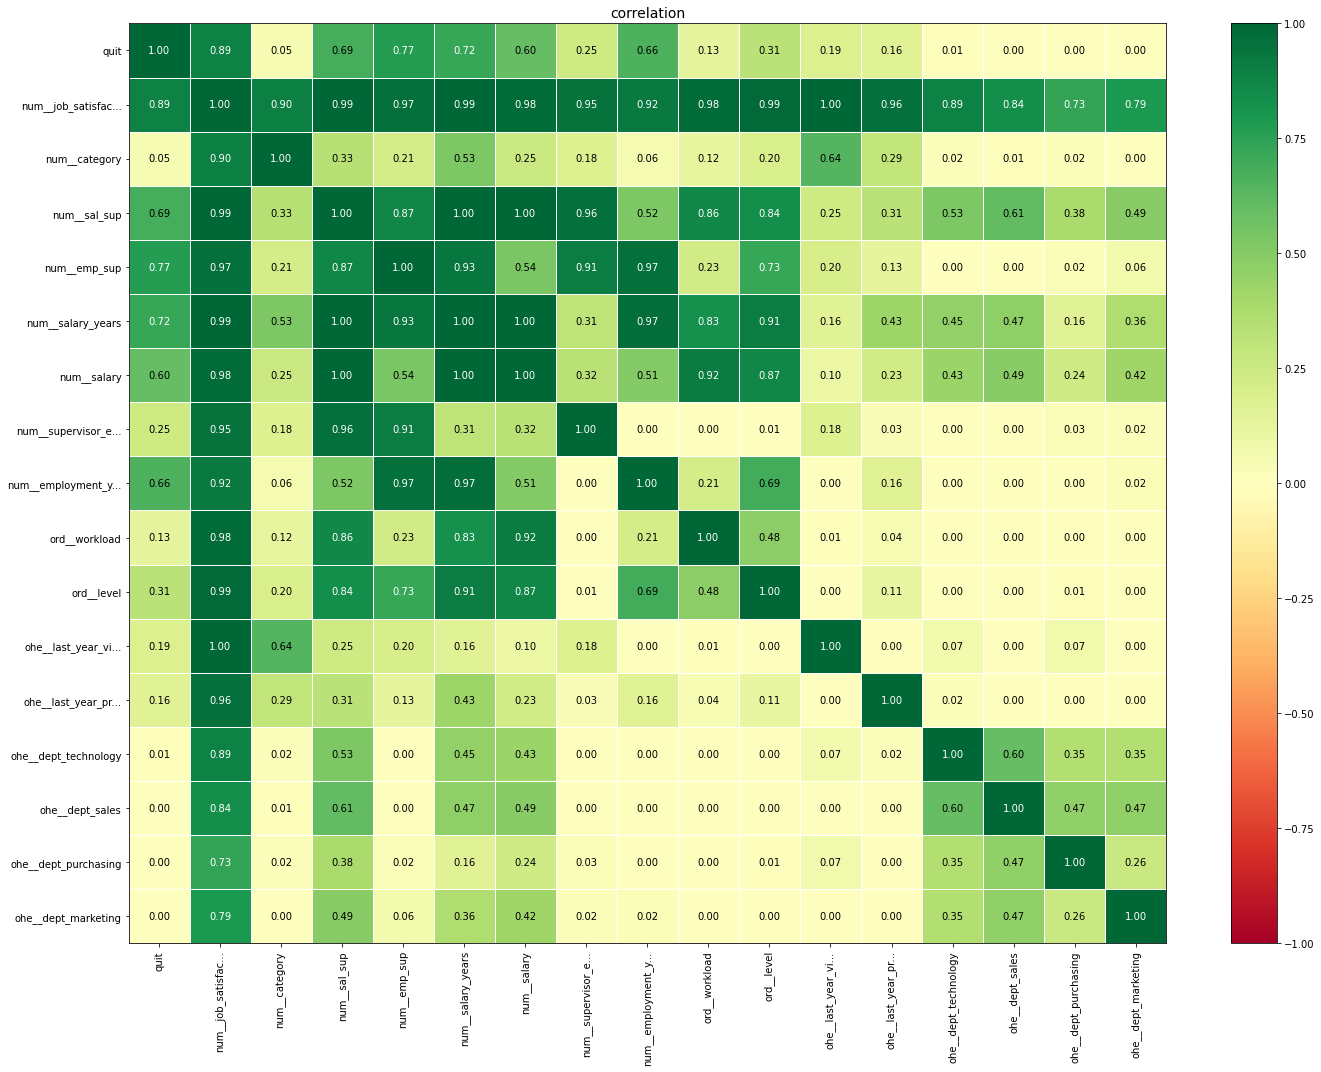

In [86]:
# Построение матрицы корреляции:
X_train_quit_matrix = X_train_quit_p.assign(quit = y_train_quit)
interval_cols = ['quit']
phik_overview = X_train_quit_matrix.phik_matrix(interval_cols = interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(20, 15))

Мультиколлинеарность присутствует, однако на предсказаниях модели особо не сказывается. Метрика достаточно высока, дополнительный прирост не требуется.

Часть признаков можно удалить, но качество модели итак высоко.

### Выводы

##### Отчёт о проделанной работе:

После распаковки файлов никаких видимых недочётов в новых таблицах не наблюдается. Переходим к предобработке.

В ходе предобработки данных проверили новые таблицы на дубликаты и корректность записи данных. Никаких сбоев не обнаружено, можно переходить к исследовательскому анализу.

С помощью лучшей модели из первой задачи предсказаны оценки компании от сотрудников. Теперь данные готовы к полному анализу.

В ходе проведения исследовательского анализа были построены диграммы размаха для количественных данных и гистограммы для качественных.

По графикам рассеяния можно сделать следующие выводы: 
  - В основном увольняются новички, предельный срок - 3 года. Конечно, есть и единичные случаи с более длительным стажем.
  - Сразу видно, что зарплата выше 80000 считается престижной, ни один человек с этой суммой не уволнялся.
  - Те, кто уволился, оценивали компанию максимум на 0.75, но и не ниже 0.15.
  
По анализу гистограмм можно сказать следующее:
  - Во всех отделах уволилась одинаковая часть сотрудников.
  - Больше всего уволилось сотрудников с низкой нагрузкой. Хотят работать, а им не дают.
  - Увольнялись только те, кого не повышали.
  - Практически 40% тех, кто нарушил, уволилось.
  - Больше всего уволилось тех, кого оценили на троечку.
  - Увольнялись те, кто оценивал компанию чуть выше 0.3. А вот остались как раз люди с оценкой 0.65.
  
Портрет уволившегося сотрудника: работал в компании меньше 3 лет, получал зарплату меньше 80000, оценивал компанию максимум на 0.75, был в отделе продаж, с низкой трудовой нагрузкой, не получал повышения в течение года, руковоство несильно ценило.

В ходе выполнения работы были преобразованы начальные таблицы (индексы заменены на id сотрудников), тренировочная выборка разделена, написан пайплайн, отвечающая за обработку данных.

В результате выбрана лучшая модель логистической регрессии: SVC(probability=True, random_state=42). С помощью неё совершены предсказания увольнения сотрудников.
   
##### Итог и рекомендации:
Работа выполнена в полном объёме, обученная модель МО имеет достаточно высокую метрику (ROC-AUC > 0.91) и в дополнительных данных не нуждается. Дополнительные исследования в рамках этой задачи не понадобятся.

## Итоговые выводы проекта

### Отчёт по проделанной работе:
Данный проект заключался из двух взаимосвязанных частей: задачи №1 (предсказание оценки компании сотрудником) и задачи №2 (предсказание увольнения сотрудников). 

Общий план работы заключался в следующем:
  - обзор полученных данных;
  - предобработка данных;
  - проведение анализа по конкретным столбцам;
  - обработка данных для модели МО;
  - обучение моделей;
  - выбор лучшей модели;
  - объяснение закономерностей предсказания модели;
  - написание общего вывода.
  
В результате произведена следующаяя работа:

  1) В ходе предобработки данных проверили новые таблицы на дубликаты и корректность записи данных. Никаких сбоев не обнаружено, можно переходить к исследовательскому анализу.
  
  2) В ходе проведения исследовательского анализа были построены диграммы размаха для количественных данных и гистограммы для качественных.
  
  3) Подготовлены пайплайны для преобразования данных и подбора лучших моделей линейной и логистической регрессий.
  
  4) Выбраны лучшие модели и на их основе совершены прогнозы целевых признаков.
  
Лучшая модель линейной регрессии: DecisionTreeRegressor(max_depth=14, max_features=10, min_samples_split=13, random_state=42).

Лучшая модель логистической регрессии: SVC(probability=True, random_state=42).
  
Составлен портрет уволняющегося сотрудника: работал в компании меньше 3 лет, получал зарплату меньше 80000, оценивал компанию максимум на 0.75, был в отделе продаж, с низкой трудовой нагрузкой, не получал повышения в течение года, руковоство несильно ценило.

### Рекомендации для компании:
По результатам моделирования можно составить список рекомендаций для улучшения отношения сотрудника к компании, а также для предотвращения утечки кадров.

Для повышения оценок:
  - высоко оценивать сотрудника;
  - держать достойный уровень оплаты труда;
  - не препятствовать продвижению по карьерной лестнице.
  
Для предотвращения увольнения:
  - давать сотруднику адекватный объём работы - не перегружать и не давать сильно расслабляться;
  - необходимо поддерживать моральный дух сотрудника - хвалить его, высоко оценивать;
  - по возможности повышать в должности, а также поощрять материально;
  - следить за обратной связью - чем выше сотрудник оценивает компанию, тем больше его желание остаться в ней.
  
Стоит также помнить, что многое зависит от целей компании и интересности решения её задач. Для большего понимания картины можно было бы опросить сотрудников на предмет их вовлечённости в дела фирмы и внести эти данные для дополнительного исследования.